# Protein–Protein Interactions Laboratory
## Teacher's Solution Notebook

This notebook contains fully solved exercises for the Protein–Protein Interactions laboratory session. Each task demonstrates practical bioinformatics analysis using real biological data and APIs.

**Learning Objectives:**
- Retrieve protein-protein interaction data from public databases
- Build and analyze protein interaction networks
- Apply graph theory concepts to biological systems
- Use machine learning for interaction prediction
- Understand network robustness and biological implications


In [1]:
# Import required libraries
import requests
import networkx as nx
import matplotlib.pyplot as plt
import json
import os
from collections import defaultdict
import numpy as np
import pandas as pd
import seaborn as sns

# Configure plotting
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
print("✓ Libraries imported successfully")


✓ Libraries imported successfully


## Task 1: Retrieve PPI Data from STRING API

**Aim:** Retrieve first-neighbor protein-protein interactions (PPIs) from the STRING database for two proteins: **PARG** (Poly(ADP-ribose) glycohydrolase) and **TP53** (p53 tumor suppressor). Compare their interaction networks by analyzing the interaction scores.

**Background:** STRING (Search Tool for the Retrieval of Interacting Genes/Proteins) is a database of known and predicted protein-protein interactions. It integrates data from multiple sources including experimental evidence, computational predictions, and text mining. First neighbors are proteins that directly interact with the query protein.

**Key Concepts:**
- REST API usage for biological databases
- Protein identifiers and species taxonomy IDs
- Interaction confidence scores
- Dataframe manipulation for comparing datasets
- Statistical analysis of interaction scores


In [2]:
def string_first_neighbors(protein, species=9606, min_score=0.7):
    """
    Retrieve first neighbors of a protein using STRING interactors API.
    Returns list of (protein1, protein2, score)
    """
    url = f"https://string-db.org/api/json/interaction_partners?identifier={protein}&species={species}"
    response = requests.get(url)
    if not response.ok:
        raise RuntimeError(f"STRING API error: {response.text}")

    data = response.json()
    edges = [(protein, e["preferredName_B"], e["score"]) for e in data if e["score"] >= min_score]
    return edges

In [3]:
# Task 1: Retrieve PPI data from STRING API for PARG and TP53
# Species ID 9606 = Homo sapiens (human)

proteins = ["PARG", "TP53"]
species_id = 9606  # Human
min_score = 0.7  # Minimum confidence score threshold

print("=" * 60)
print("Task 1: Retrieving First Neighbors from STRING Database")
print("=" * 60)

# Retrieve interactions for both proteins
dataframes = {}

for protein in proteins:
    print(f"\nFetching STRING first neighbors for {protein}...")
    
    try:
        # Use string_first_neighbors function
        interactions = string_first_neighbors(protein, species=species_id, min_score=min_score)
        
        # Create DataFrame
        df = pd.DataFrame(interactions, columns=['Protein_A', 'Protein_B', 'Score'])
        dataframes[protein] = df
        
        print(f"✓ Retrieved {len(df)} interactions for {protein}")
        print(f"  First 3 interactions:")
        for idx, row in df.head(3).iterrows():
            print(f"    {row['Protein_A']} ↔ {row['Protein_B']} (score: {row['Score']:.3f})")
            
    except Exception as e:
        print(f"✗ Error fetching data for {protein}: {e}")
        # Create empty dataframe as fallback
        dataframes[protein] = pd.DataFrame(columns=['Protein_A', 'Protein_B', 'Score'])

# Display statistics for each protein
print("\n" + "=" * 60)
print("Interaction Score Statistics")
print("=" * 60)

for protein in proteins:
    df = dataframes[protein]
    if len(df) > 0:
        scores = df['Score']
        print(f"\n{protein} ({len(df)} interactions):")
        print(f"  Mean score: {scores.mean():.3f}")
        print(f"  Max score:  {scores.max():.3f}")
        print(f"  Min score:  {scores.min():.3f}")
        print(f"  Median:     {scores.median():.3f}")
        print(f"  Std dev:    {scores.std():.3f}")
    else:
        print(f"\n{protein}: No interactions found (or error occurred)")

# Display dataframes
print("\n" + "=" * 60)
print("DataFrames Summary")
print("=" * 60)

for protein in proteins:
    df = dataframes[protein]
    print(f"\n{protein} DataFrame:")
    print(df.head(10).to_string(index=False))
    if len(df) > 10:
        print(f"... and {len(df) - 10} more rows")

# Compare the two networks
if len(dataframes["PARG"]) > 0 and len(dataframes["TP53"]) > 0:
    print("\n" + "=" * 60)
    print("Network Comparison")
    print("=" * 60)
    print(f"PARG has {len(dataframes['PARG'])} first neighbors")
    print(f"TP53 has {len(dataframes['TP53'])} first neighbors")
    
    # Find common interactors
    parg_partners = set(dataframes['PARG']['Protein_B'])
    tp53_partners = set(dataframes['TP53']['Protein_B'])
    common = parg_partners & tp53_partners
    
    print(f"\nCommon interactors: {len(common)}")
    if len(common) > 0:
        print(f"  Examples: {', '.join(list(common)[:5])}")


Task 1: Retrieving First Neighbors from STRING Database

Fetching STRING first neighbors for PARG...
✓ Retrieved 10 interactions for PARG
  First 3 interactions:
    PARG ↔ PARP1 (score: 0.992)
    PARG ↔ PARP2 (score: 0.980)
    PARG ↔ PCNA (score: 0.910)

Fetching STRING first neighbors for TP53...
✓ Retrieved 10 interactions for TP53
  First 3 interactions:
    TP53 ↔ SFN (score: 0.999)
    TP53 ↔ EP300 (score: 0.999)
    TP53 ↔ HIF1A (score: 0.999)

Interaction Score Statistics

PARG (10 interactions):
  Mean score: 0.874
  Max score:  0.992
  Min score:  0.796
  Median:     0.869
  Std dev:    0.069

TP53 (10 interactions):
  Mean score: 0.999
  Max score:  0.999
  Min score:  0.999
  Median:     0.999
  Std dev:    0.000

DataFrames Summary

PARG DataFrame:
Protein_A Protein_B  Score
     PARG     PARP1  0.992
     PARG     PARP2  0.980
     PARG      PCNA  0.910
     PARG      ART5  0.881
     PARG   ADPRHL2  0.875
     PARG  ARHGAP29  0.863
     PARG   MACROD1  0.822
     PARG 

## Task 2: Build n-Hop Neighborhood Graphs using BFS

**Aim:** Use Breadth-First Search (BFS) to find all proteins within n hops (default n=2) from the target proteins (PARG and TP53), and also retrieve all interactions between these discovered proteins. This creates a complete interaction subgraph centered on each target protein.

**Background:** A protein-centered network includes not only direct interactors but also their interactions with each other. This provides a more complete view of the local interaction neighborhood. BFS systematically explores the network layer by layer, ensuring we capture all proteins within the specified distance.

**Key Concepts:**
- Breadth-First Search (BFS) algorithm for network exploration
- n-hop neighborhood discovery
- Building complete subgraphs (nodes + all edges between them)
- Graph construction from interaction data
- Network visualization with spring layout


In [4]:
def string_n_hop_neighbors(
    protein,
    n=2,
    species=9606,
    min_score=0.7
):
    """
    Retrieve nodes and edges up to n hops away from the input protein
    using BFS (Breadth-First Search). Also retrieves all interactions
    between the discovered nodes to build a complete subgraph.
    
    Algorithm:
    1. Use BFS to discover all nodes within n hops
    2. For each discovered node, get all its first neighbors
    3. Filter to keep only edges between discovered nodes
    4. Return all edges in the subgraph
    
    Returns edges in the same format as string_first_neighbors:
        [(protein1, protein2, score), ...]
    """
    
    # Step 1: BFS to discover all nodes within n hops
    frontier = {protein}
    visited = {protein}
    
    for hop in range(n):
        new_frontier = set()
        
        for p in frontier:
            try:
                # Get first neighbors
                edges = string_first_neighbors(
                    p,
                    species=species,
                    min_score=min_score
                )
                
                # Add new neighbors to visited and next frontier
                for (_, partner, _) in edges:
                    if partner not in visited:
                        new_frontier.add(partner)
                        visited.add(partner)
                        
            except Exception as e:
                print(f"Warning: Could not fetch neighbors for {p}: {e}")
                continue
        
        frontier = new_frontier
        if not frontier:
            break
    
    # Step 2: Get all interactions between discovered nodes
    all_edges = []
    discovered_nodes = list(visited)
    
    print(f"  Discovered {len(discovered_nodes)} nodes, fetching all interactions...")
    
    # Fetch interactions for each discovered node
    for i, node in enumerate(discovered_nodes):
        if (i + 1) % 10 == 0:
            print(f"    Progress: {i+1}/{len(discovered_nodes)} nodes processed...")
        
        try:
            edges = string_first_neighbors(
                node,
                species=species,
                min_score=min_score
            )
            
            # Only keep edges where both nodes are in our discovered set
            for (p1, p2, score) in edges:
                if p2 in visited:  # Both nodes are in discovered set
                    # Avoid duplicates by using sorted tuple
                    edge_tuple = tuple(sorted([p1, p2]))
                    all_edges.append((p1, p2, score))
                    
        except Exception as e:
            print(f"    Warning: Could not fetch neighbors for {node}: {e}")
            continue
    
    # Remove duplicate edges (keep first occurrence)
    seen = set()
    unique_edges = []
    for edge in all_edges:
        edge_key = tuple(sorted([edge[0], edge[1]]))
        if edge_key not in seen:
            seen.add(edge_key)
            unique_edges.append(edge)
    
    print(f"  Retrieved {len(unique_edges)} unique interactions")
    return unique_edges

In [5]:
# Task 2: Build n-hop neighborhood graphs for PARG and TP53
n_hops = 2  # Number of hops from target protein
species_id = 9606  # Human
min_score = 0.7  # Minimum confidence score

print("=" * 60)
print("Task 2: Building n-Hop Neighborhood Graphs (BFS)")
print("=" * 60)

# Store graphs for each protein
graphs = {}

for protein in ["PARG", "TP53"]:
    print(f"\n{'='*60}")
    print(f"Processing {protein} (n={n_hops} hops)")
    print(f"{'='*60}")
    
    try:
        # Get all edges in the n-hop neighborhood
        edges = string_n_hop_neighbors(
            protein,
            n=n_hops,
            species=species_id,
            min_score=min_score
        )
        
        # Build NetworkX graph
        G = nx.Graph()
        for p1, p2, score in edges:
            G.add_edge(p1, p2, weight=score)
        
        graphs[protein] = G
        
        print(f"\n✓ Graph constructed for {protein}:")
        print(f"  Nodes: {G.number_of_nodes()}")
        print(f"  Edges: {G.number_of_edges()}")
        print(f"  Density: {nx.density(G):.4f}")
        print(f"  Is connected: {nx.is_connected(G)}")
        
        if not nx.is_connected(G):
            components = list(nx.connected_components(G))
            print(f"  Connected components: {len(components)}")
            print(f"  Largest component: {len(max(components, key=len))} nodes")
        
    except Exception as e:
        print(f"✗ Error building graph for {protein}: {e}")
        import traceback
        traceback.print_exc()
        graphs[protein] = nx.Graph()  # Empty graph as fallback

# Compare the two graphs
print("\n" + "=" * 60)
print("Graph Comparison")
print("=" * 60)

if len(graphs["PARG"].nodes()) > 0 and len(graphs["TP53"].nodes()) > 0:
    print(f"\nPARG graph: {graphs['PARG'].number_of_nodes()} nodes, {graphs['PARG'].number_of_edges()} edges")
    print(f"TP53 graph: {graphs['TP53'].number_of_nodes()} nodes, {graphs['TP53'].number_of_edges()} edges")
    
    # Find common nodes
    parg_nodes = set(graphs['PARG'].nodes())
    tp53_nodes = set(graphs['TP53'].nodes())
    common_nodes = parg_nodes & tp53_nodes
    
    print(f"\nCommon nodes: {len(common_nodes)}")
    if len(common_nodes) > 0:
        print(f"  Examples: {', '.join(list(common_nodes)[:10])}")


Task 2: Building n-Hop Neighborhood Graphs (BFS)

Processing PARG (n=2 hops)
  Discovered 63 nodes, fetching all interactions...
    Progress: 10/63 nodes processed...
    Progress: 20/63 nodes processed...
    Progress: 30/63 nodes processed...
    Progress: 40/63 nodes processed...
    Progress: 50/63 nodes processed...
    Progress: 60/63 nodes processed...
  Retrieved 135 unique interactions

✓ Graph constructed for PARG:
  Nodes: 63
  Edges: 135
  Density: 0.0691
  Is connected: True

Processing TP53 (n=2 hops)
  Discovered 82 nodes, fetching all interactions...
    Progress: 10/82 nodes processed...
    Progress: 20/82 nodes processed...
    Progress: 30/82 nodes processed...
    Progress: 40/82 nodes processed...
    Progress: 50/82 nodes processed...
    Progress: 60/82 nodes processed...
    Progress: 70/82 nodes processed...
    Progress: 80/82 nodes processed...
  Retrieved 202 unique interactions

✓ Graph constructed for TP53:
  Nodes: 82
  Edges: 202
  Density: 0.0608
  Is

## Task 3: Visualize PPI Networks

**Aim:** Visualize the n-hop neighborhood graphs created in Task 2 for PARG and TP53. Create publication-quality network visualizations with proper node highlighting, edge styling, and layout algorithms.

**Background:** Network visualization is crucial for understanding the structure and organization of protein interaction networks. Different layout algorithms (spring, circular, hierarchical) can reveal different aspects of network topology. Visual elements like node size, color, and edge thickness can encode additional information.

**Key Concepts:**
- Network visualization techniques
- Layout algorithms (spring, circular, hierarchical)
- Node and edge styling
- Highlighting important nodes (e.g., target proteins)
- Saving publication-quality figures


Task 3: Visualizing PPI Networks

Visualizing PARG network
Graph: 63 nodes, 135 edges


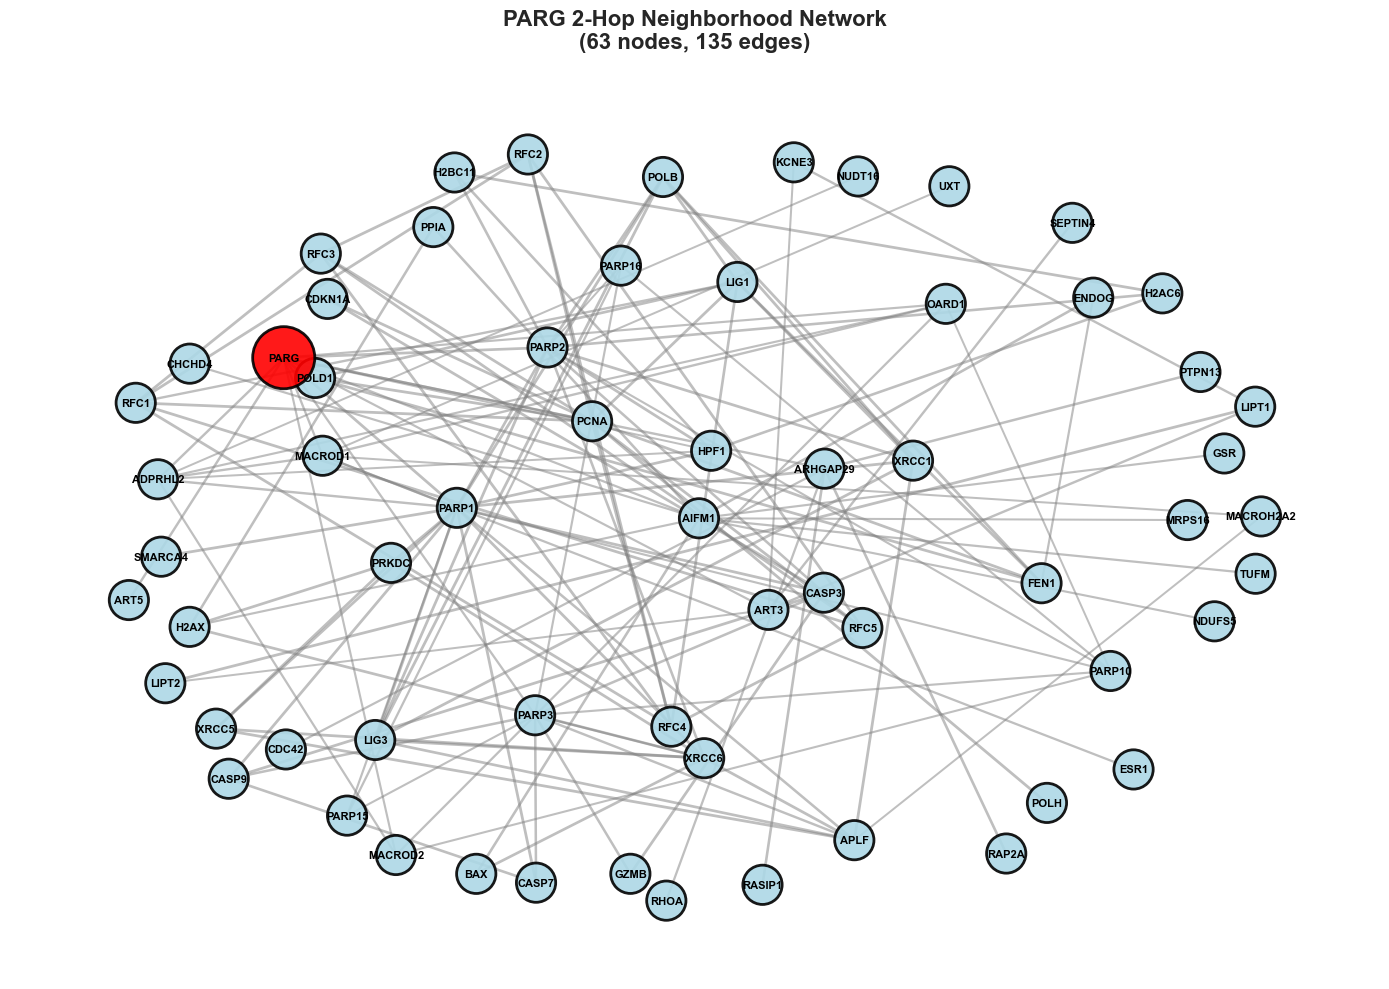

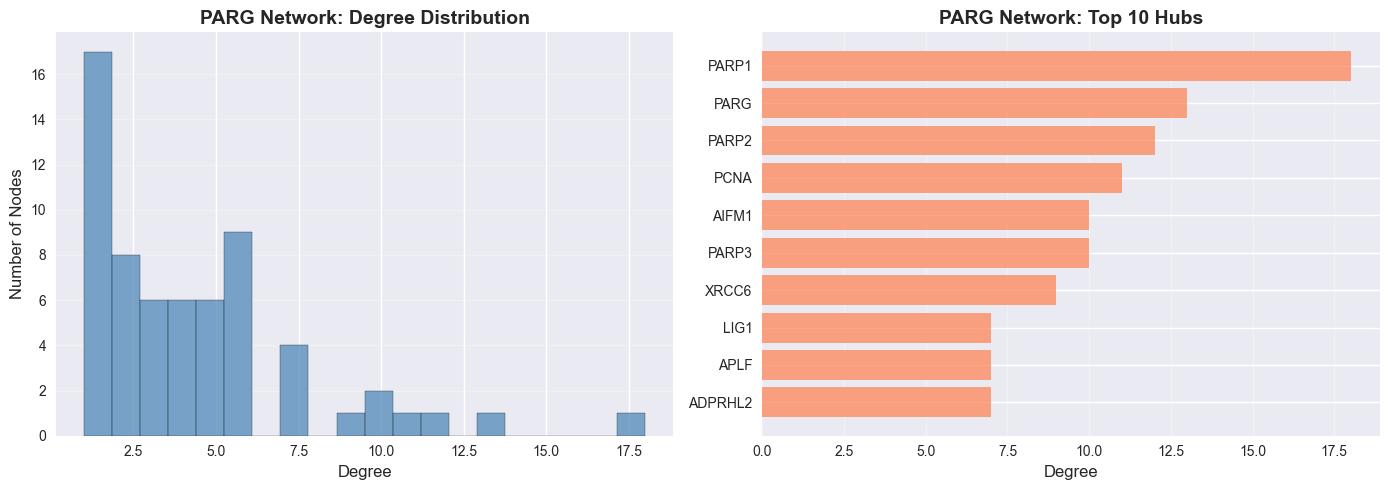


Visualizing TP53 network
Graph: 82 nodes, 202 edges


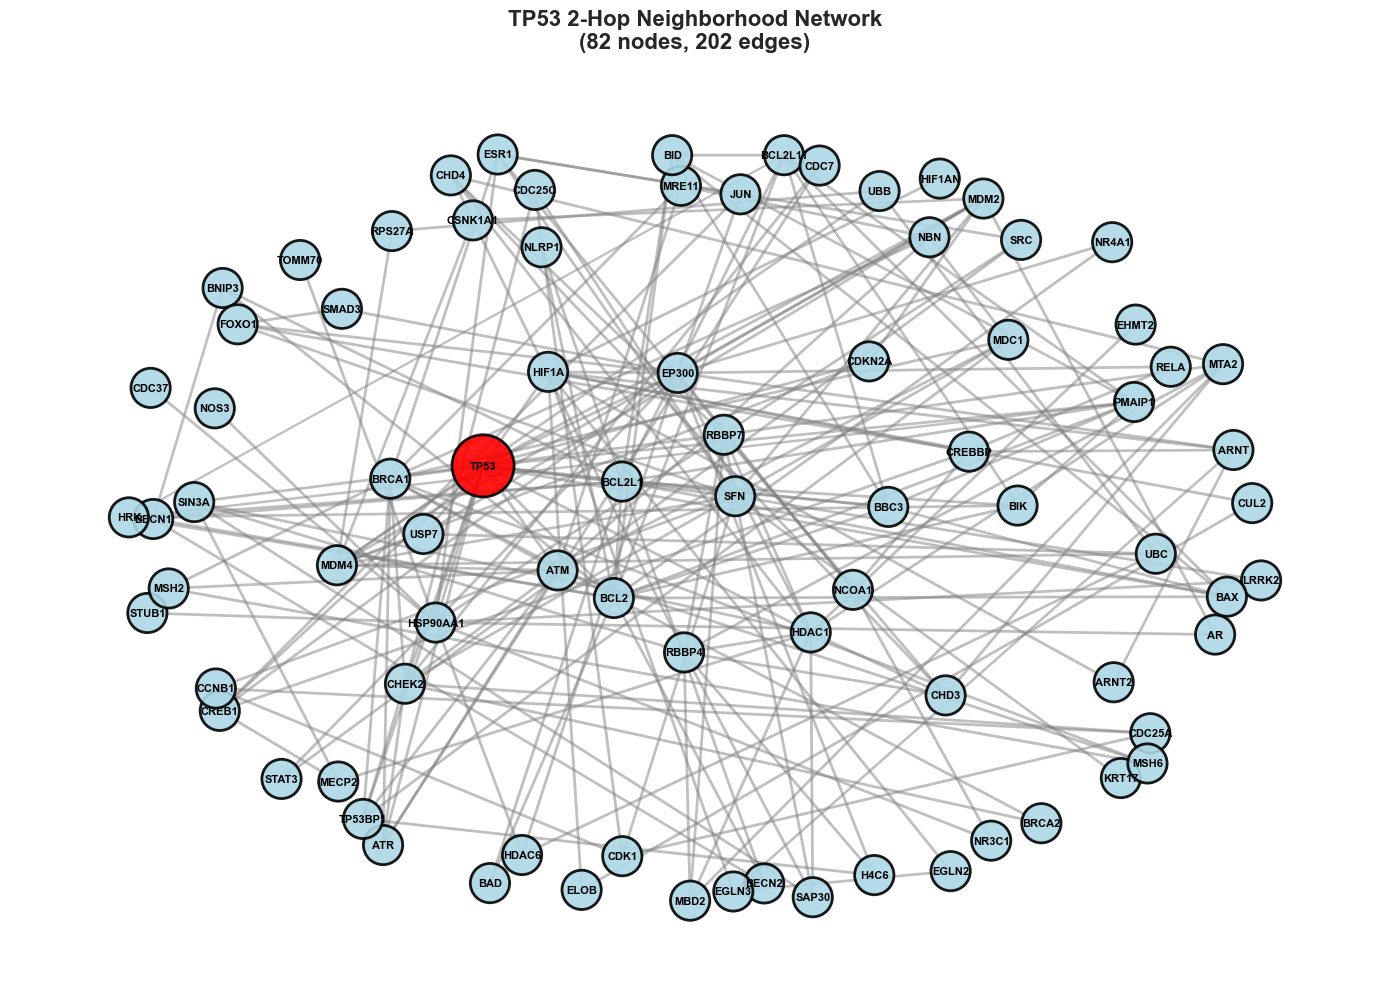

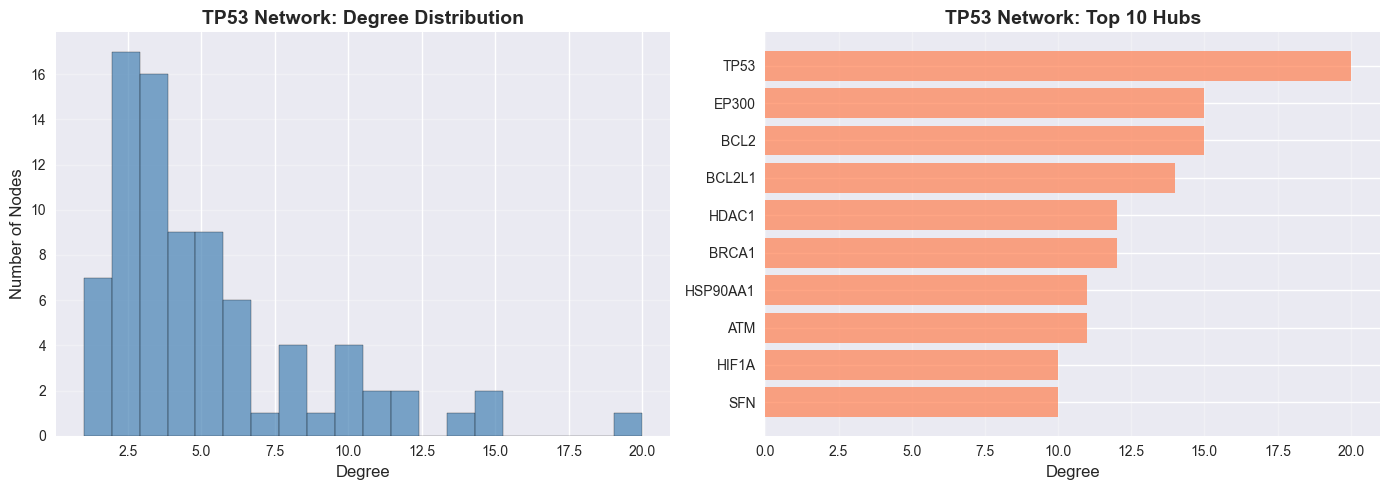


Visualization Complete


In [6]:
# Task 3: Visualize the n-hop neighborhood graphs
print("=" * 60)
print("Task 3: Visualizing PPI Networks")
print("=" * 60)

# Check if graphs were created in Task 2
if 'graphs' not in locals() or len(graphs) == 0:
    print("⚠ Warning: Graphs not found. Please run Task 2 first.")
else:
    for protein in ["PARG", "TP53"]:
        if protein not in graphs or graphs[protein].number_of_nodes() == 0:
            print(f"⚠ Warning: No graph available for {protein}")
            continue
        
        G = graphs[protein]
        print(f"\n{'='*60}")
        print(f"Visualizing {protein} network")
        print(f"{'='*60}")
        print(f"Graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")
        
        # Create visualization
        plt.figure(figsize=(14, 10))
        
        # Use spring layout for better visualization
        pos = nx.spring_layout(G, seed=42, k=1.5, iterations=50)
        
        # Highlight the target protein
        node_colors = ['red' if node == protein else 'lightblue' for node in G.nodes()]
        node_sizes = [2000 if node == protein else 800 for node in G.nodes()]
        
        # Draw nodes
        nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes,
                              alpha=0.9, edgecolors='black', linewidths=2)
        
        # Draw edges (optionally weight by score)
        edges = G.edges(data=True)
        edge_widths = [data.get('weight', 1.0) * 2 for _, _, data in edges]
        nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.5, edge_color='gray')
        
        # Draw labels
        nx.draw_networkx_labels(G, pos, font_size=8, font_weight='bold')
        
        plt.title(f"{protein} {n_hops}-Hop Neighborhood Network\n"
                 f"({G.number_of_nodes()} nodes, {G.number_of_edges()} edges)",
                 fontsize=16, fontweight='bold', pad=20)
        plt.axis('off')
        plt.tight_layout()
        plt.show()
        
        # Additional visualization: Degree distribution
        degrees = dict(G.degree())
        degree_values = list(degrees.values())
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
        
        # Degree distribution histogram
        ax1.hist(degree_values, bins=20, color='steelblue', edgecolor='black', alpha=0.7)
        ax1.set_xlabel('Degree', fontsize=12)
        ax1.set_ylabel('Number of Nodes', fontsize=12)
        ax1.set_title(f'{protein} Network: Degree Distribution', fontsize=14, fontweight='bold')
        ax1.grid(axis='y', alpha=0.3)
        
        # Top 10 nodes by degree
        top_degree_nodes = sorted(degrees.items(), key=lambda x: x[1], reverse=True)[:10]
        nodes_list = [node for node, _ in top_degree_nodes]
        degree_list = [deg for _, deg in top_degree_nodes]
        
        ax2.barh(range(len(nodes_list)), degree_list, color='coral', alpha=0.7)
        ax2.set_yticks(range(len(nodes_list)))
        ax2.set_yticklabels(nodes_list)
        ax2.set_xlabel('Degree', fontsize=12)
        ax2.set_title(f'{protein} Network: Top 10 Hubs', fontsize=14, fontweight='bold')
        ax2.invert_yaxis()
        ax2.grid(axis='x', alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    print("\n" + "=" * 60)
    print("Visualization Complete")
    print("=" * 60)


## Task 4: Centrality Analysis


**Aim:** Compute graph centrality measures to identify key proteins (hubs) in the network.

**Background:** Centrality measures quantify the importance of nodes in a network:
- **Degree centrality**: Number of connections (simple but effective)
- **Betweenness centrality**: How often a node lies on shortest paths between other nodes
- **Closeness centrality**: Average distance to all other nodes

**Biological Significance:** Hub proteins (high centrality) are often:
- Essential for cellular function
- Key regulators in signaling pathways
- Important drug targets
- Associated with disease when mutated


Task 4: Graph Analysis and Centrality Measures

Analyzing PARG Network

Basic Graph Statistics:
  Number of nodes: 63
  Number of edges: 135
  Number of connected components: 1
  Is connected: True

Computing centrality measures...
✓ Centrality measures computed

Top 10 hub proteins (by degree centrality):
           degree  betweenness  closeness
Protein                                  
PARP1    0.290323     0.209448   0.480620
PARG     0.209677     0.595504   0.558559
PARP2    0.193548     0.090435   0.446043
PCNA     0.177419     0.216473   0.418919
AIFM1    0.161290     0.225551   0.410596
PARP3    0.161290     0.079541   0.424658
XRCC6    0.145161     0.038417   0.375758
LIG1     0.112903     0.027534   0.340659
ADPRHL2  0.112903     0.038254   0.421769
MACROD1  0.112903     0.085014   0.416107


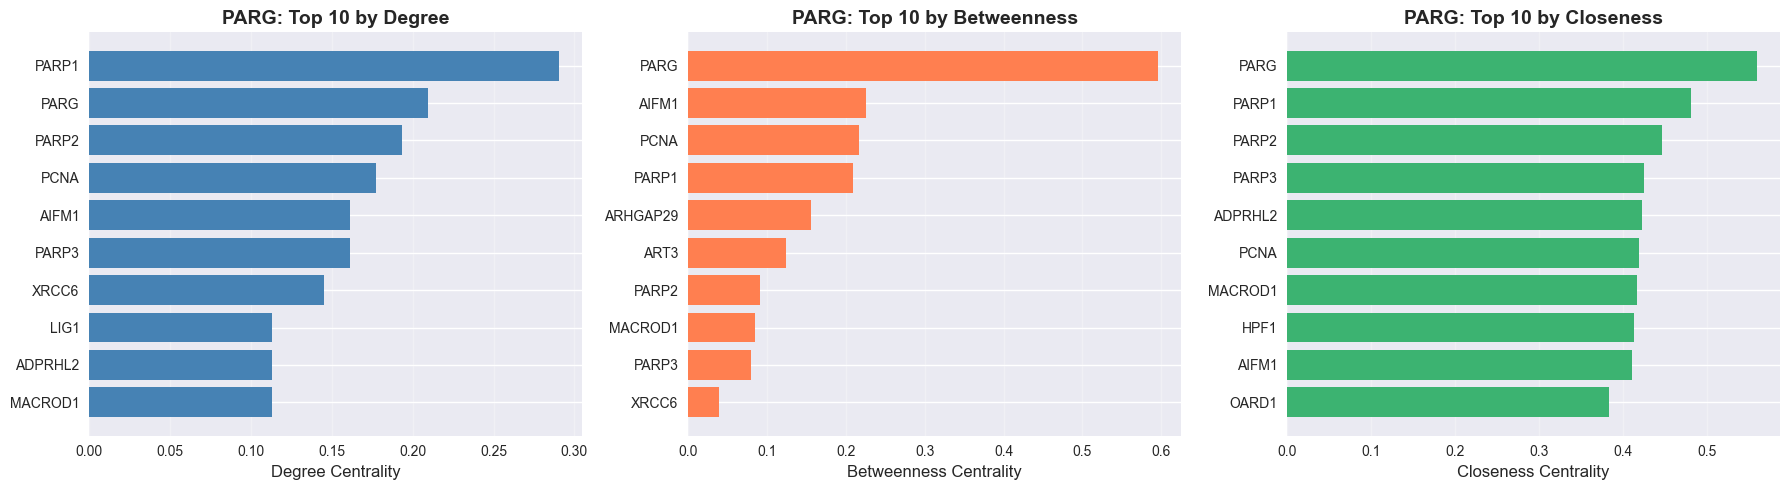


Correlation between centrality measures (PARG):
               degree  betweenness  closeness
degree       1.000000     0.678469   0.859186
betweenness  0.678469     1.000000   0.771700
closeness    0.859186     0.771700   1.000000

Visualizing network with top-centrality nodes highlighted...


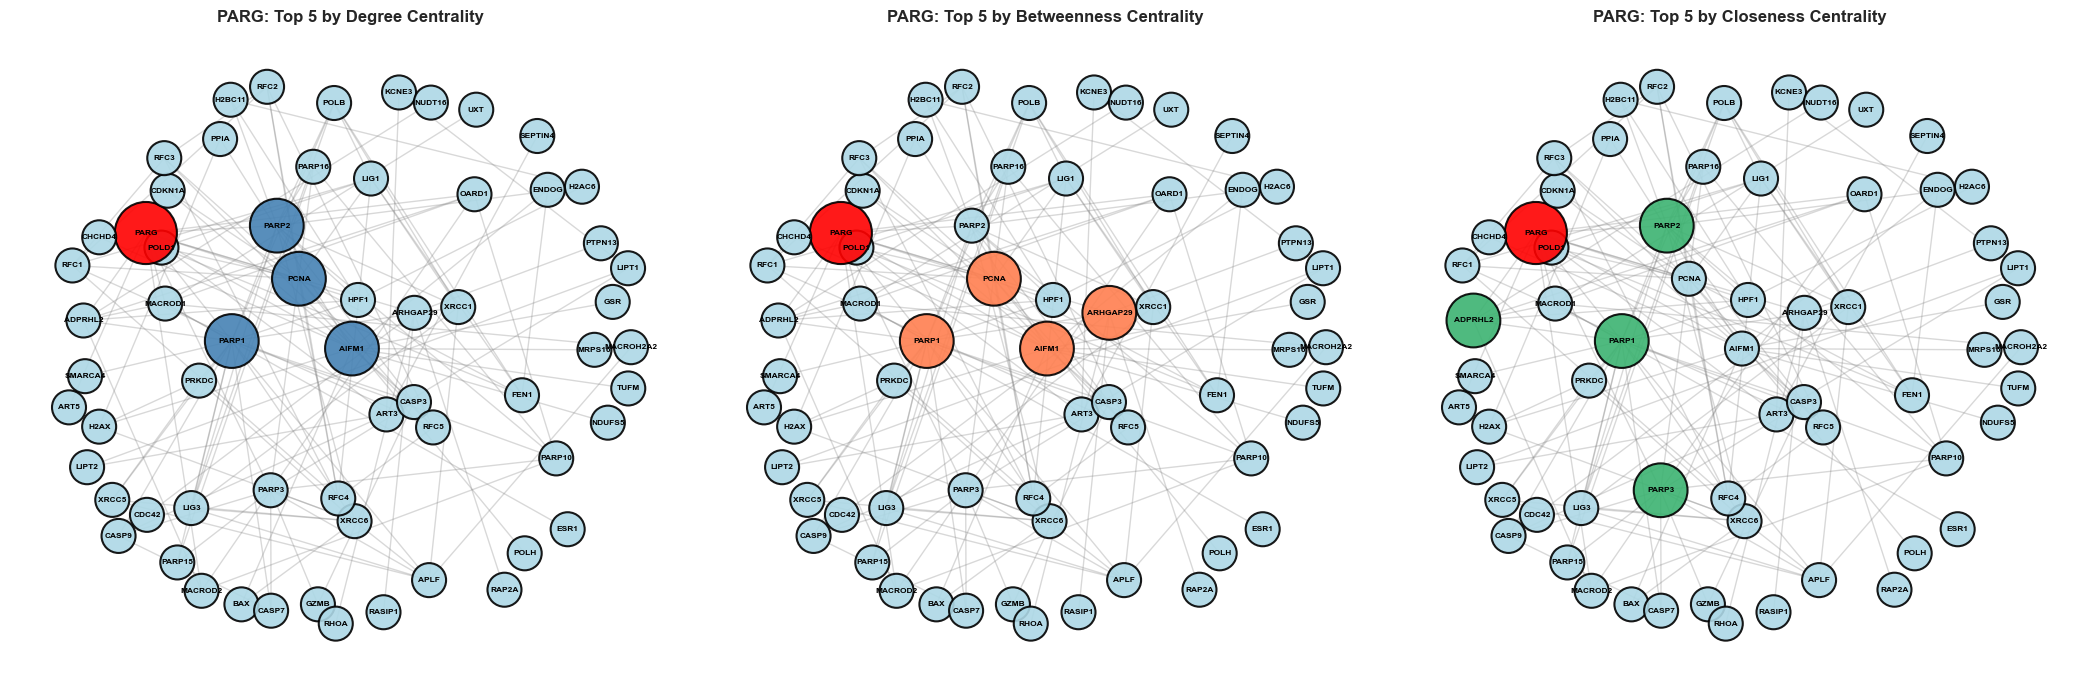


Top 5 nodes by centrality (PARG):
  Degree: PARG, PCNA, PARP2, PARP1, AIFM1
  Betweenness: PARG, PCNA, ARHGAP29, PARP1, AIFM1
  Closeness: PARG, ADPRHL2, PARP3, PARP2, PARP1

Analyzing TP53 Network

Basic Graph Statistics:
  Number of nodes: 82
  Number of edges: 202
  Number of connected components: 1
  Is connected: True

Computing centrality measures...
✓ Centrality measures computed

Top 10 hub proteins (by degree centrality):
            degree  betweenness  closeness
Protein                                   
TP53      0.246914     0.596242   0.570423
EP300     0.185185     0.186810   0.462857
BCL2      0.185185     0.092014   0.409091
BCL2L1    0.172840     0.078285   0.407035
HDAC1     0.148148     0.202033   0.424084
BRCA1     0.148148     0.072504   0.411168
HSP90AA1  0.135802     0.147786   0.409091
ATM       0.135802     0.056285   0.411168
MDM4      0.123457     0.072786   0.415385
HIF1A     0.123457     0.146241   0.413265


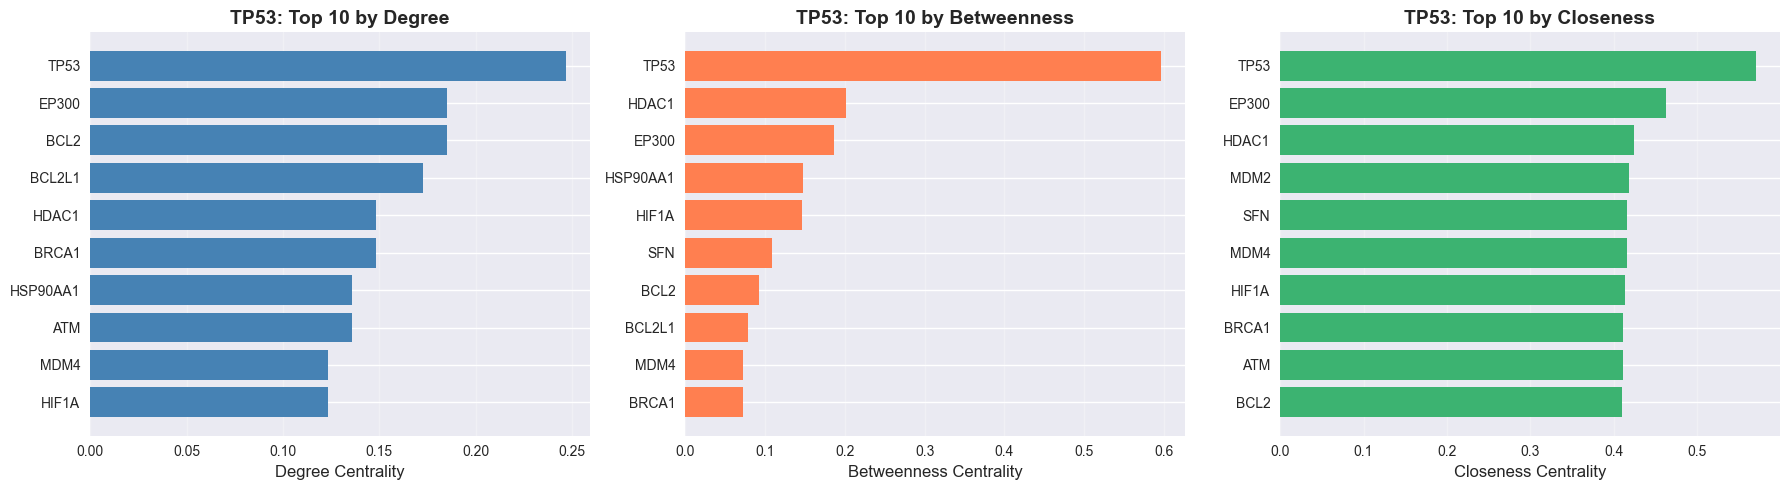


Correlation between centrality measures (TP53):
               degree  betweenness  closeness
degree       1.000000     0.757325   0.826052
betweenness  0.757325     1.000000   0.778840
closeness    0.826052     0.778840   1.000000

Visualizing network with top-centrality nodes highlighted...


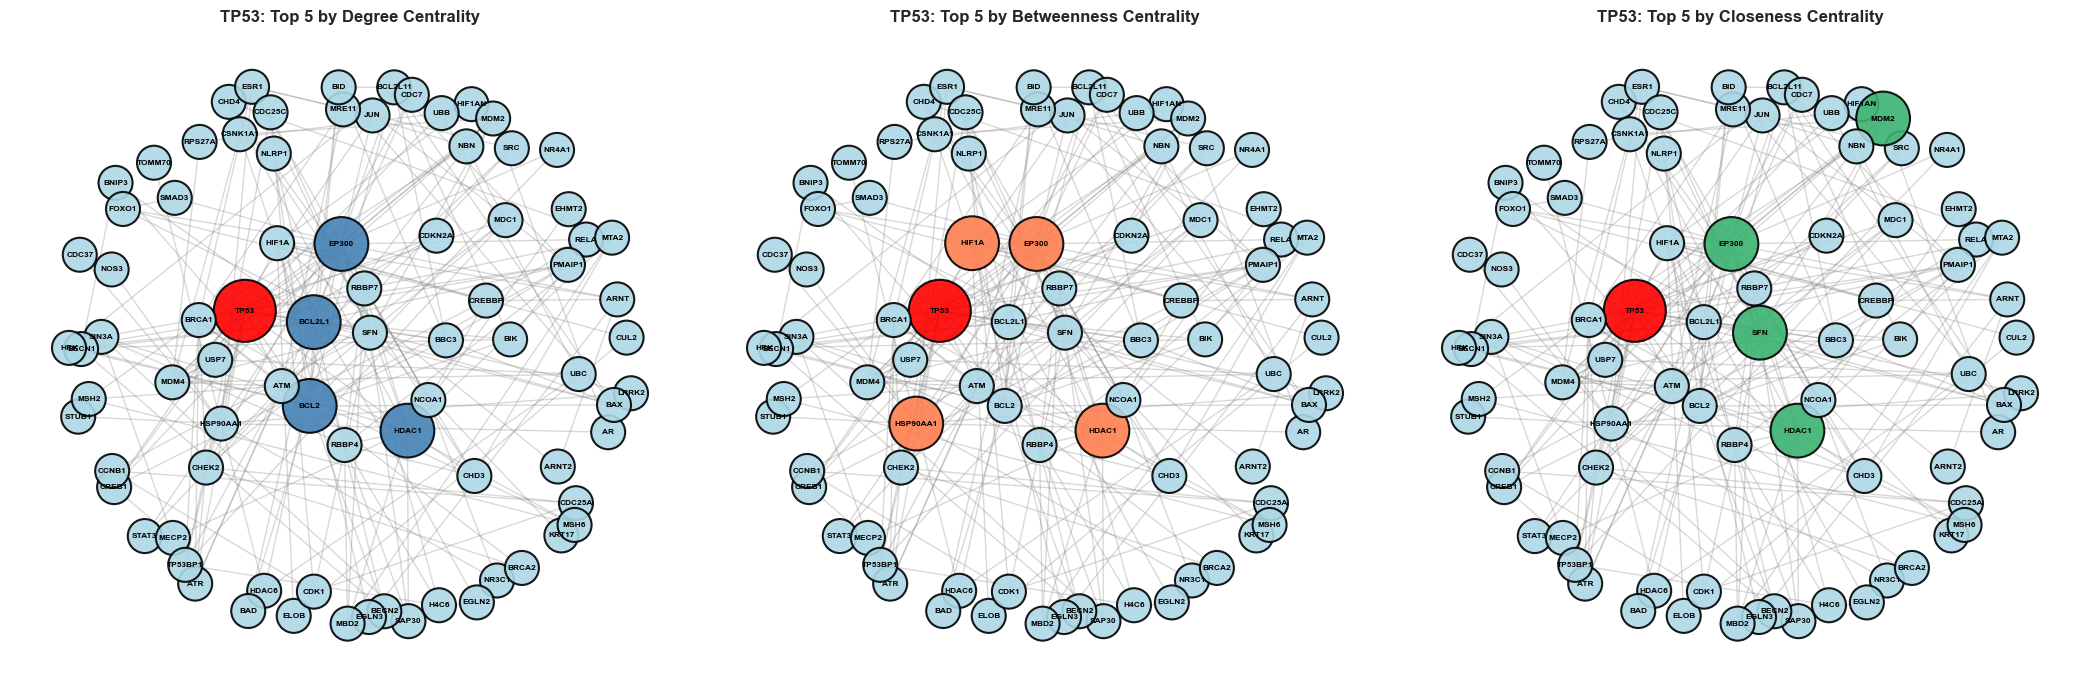


Top 5 nodes by centrality (TP53):
  Degree: HDAC1, EP300, TP53, BCL2L1, BCL2
  Betweenness: HSP90AA1, HDAC1, EP300, TP53, HIF1A
  Closeness: SFN, HDAC1, EP300, TP53, MDM2

Comparison: PARG vs TP53

Graph Size:
  PARG: 63 nodes, 135 edges
  TP53: 82 nodes, 202 edges

Connectivity:
  PARG: 1 component(s), connected: True
  TP53: 1 component(s), connected: True

Average Centrality Values:
  PARG - Degree: 0.0691, Betweenness: 0.0332, Closeness: 0.3385
  TP53 - Degree: 0.0608, Betweenness: 0.0255, Closeness: 0.3354


In [7]:
# Task 4: Graph Analysis and Centrality Measures
print("=" * 60)
print("Task 4: Graph Analysis and Centrality Measures")
print("=" * 60)

# Check if graphs were created in Task 2
if 'graphs' not in locals() or len(graphs) == 0:
    print("⚠ Warning: Graphs not found. Please run Task 2 first.")
else:
    # Store results for both graphs
    analysis_results = {}
    
    for protein in ["PARG", "TP53"]:
        if protein not in graphs or graphs[protein].number_of_nodes() == 0:
            print(f"⚠ Warning: No graph available for {protein}")
            continue
        
        G = graphs[protein]
        print(f"\n{'='*60}")
        print(f"Analyzing {protein} Network")
        print(f"{'='*60}")
        
        # Basic graph statistics
        num_nodes = G.number_of_nodes()
        num_edges = G.number_of_edges()
        components = list(nx.connected_components(G))
        num_components = len(components)
        is_connected = nx.is_connected(G)
        
        print(f"\nBasic Graph Statistics:")
        print(f"  Number of nodes: {num_nodes}")
        print(f"  Number of edges: {num_edges}")
        print(f"  Number of connected components: {num_components}")
        print(f"  Is connected: {is_connected}")
        if not is_connected:
            largest_component = max(components, key=len)
            print(f"  Largest component size: {len(largest_component)} nodes")
        
        # Calculate centrality measures
        print(f"\nComputing centrality measures...")
        degree_cent = nx.degree_centrality(G)
        betweenness_cent = nx.betweenness_centrality(G)
        closeness_cent = nx.closeness_centrality(G)
        
        # Create DataFrame
        centrality_df = pd.DataFrame({
            "degree": degree_cent,
            "betweenness": betweenness_cent,
            "closeness": closeness_cent
        })
        centrality_df.index.name = "Protein"
        centrality_df = centrality_df.sort_values("degree", ascending=False)
        
        analysis_results[protein] = {
            'graph': G,
            'centrality_df': centrality_df,
            'stats': {
                'nodes': num_nodes,
                'edges': num_edges,
                'components': num_components,
                'is_connected': is_connected
            }
        }
        
        print(f"✓ Centrality measures computed")
        print(f"\nTop 10 hub proteins (by degree centrality):")
        print(centrality_df.head(10).to_string())
        
        # Visualize centrality measures with bar plots
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        
        # Degree centrality
        top_degree = centrality_df.head(10)
        axes[0].barh(range(len(top_degree)), top_degree['degree'], color='steelblue')
        axes[0].set_yticks(range(len(top_degree)))
        axes[0].set_yticklabels(top_degree.index)
        axes[0].set_xlabel('Degree Centrality', fontsize=12)
        axes[0].set_title(f'{protein}: Top 10 by Degree', fontsize=14, fontweight='bold')
        axes[0].invert_yaxis()
        axes[0].grid(axis='x', alpha=0.3)
        
        # Betweenness centrality
        top_between = centrality_df.sort_values("betweenness", ascending=False).head(10)
        axes[1].barh(range(len(top_between)), top_between['betweenness'], color='coral')
        axes[1].set_yticks(range(len(top_between)))
        axes[1].set_yticklabels(top_between.index)
        axes[1].set_xlabel('Betweenness Centrality', fontsize=12)
        axes[1].set_title(f'{protein}: Top 10 by Betweenness', fontsize=14, fontweight='bold')
        axes[1].invert_yaxis()
        axes[1].grid(axis='x', alpha=0.3)
        
        # Closeness centrality
        top_close = centrality_df.sort_values("closeness", ascending=False).head(10)
        axes[2].barh(range(len(top_close)), top_close['closeness'], color='mediumseagreen')
        axes[2].set_yticks(range(len(top_close)))
        axes[2].set_yticklabels(top_close.index)
        axes[2].set_xlabel('Closeness Centrality', fontsize=12)
        axes[2].set_title(f'{protein}: Top 10 by Closeness', fontsize=14, fontweight='bold')
        axes[2].invert_yaxis()
        axes[2].grid(axis='x', alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Correlation between centrality measures
        print(f"\nCorrelation between centrality measures ({protein}):")
        corr = centrality_df.corr()
        print(corr.to_string())
        
        # Visualize network with top-centrality nodes highlighted
        print(f"\nVisualizing network with top-centrality nodes highlighted...")
        
        # Get top nodes for each centrality measure (top 5)
        top_degree_nodes = set(centrality_df.sort_values("degree", ascending=False).head(5).index)
        top_between_nodes = set(centrality_df.sort_values("betweenness", ascending=False).head(5).index)
        top_close_nodes = set(centrality_df.sort_values("closeness", ascending=False).head(5).index)
        
        # Create three visualizations, one for each centrality measure
        centrality_types = [
            ("degree", top_degree_nodes, "Degree Centrality", "steelblue"),
            ("betweenness", top_between_nodes, "Betweenness Centrality", "coral"),
            ("closeness", top_close_nodes, "Closeness Centrality", "mediumseagreen")
        ]
        
        fig, axes = plt.subplots(1, 3, figsize=(21, 7))
        
        # Use consistent layout for all three plots
        pos = nx.spring_layout(G, seed=42, k=1.5, iterations=50)
        
        for idx, (cent_type, top_nodes, cent_name, color) in enumerate(centrality_types):
            ax = axes[idx]
            
            # Color nodes: red for target protein, color for top centrality nodes, lightblue for others
            node_colors = []
            node_sizes = []
            for node in G.nodes():
                if node == protein:
                    node_colors.append('red')
                    node_sizes.append(2000)
                elif node in top_nodes:
                    node_colors.append(color)
                    node_sizes.append(1500)
                else:
                    node_colors.append('lightblue')
                    node_sizes.append(600)
            
            # Draw network
            nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes,
                                  alpha=0.9, edgecolors='black', linewidths=1.5, ax=ax)
            nx.draw_networkx_edges(G, pos, width=1, alpha=0.3, edge_color='gray', ax=ax)
            nx.draw_networkx_labels(G, pos, font_size=6, font_weight='bold', ax=ax)
            
            ax.set_title(f'{protein}: Top 5 by {cent_name}', fontsize=12, fontweight='bold')
            ax.axis('off')
        
        plt.tight_layout()
        plt.show()
        
        # Print top nodes for each centrality
        print(f"\nTop 5 nodes by centrality ({protein}):")
        print(f"  Degree: {', '.join(list(top_degree_nodes))}")
        print(f"  Betweenness: {', '.join(list(top_between_nodes))}")
        print(f"  Closeness: {', '.join(list(top_close_nodes))}")
    
    # Compare results between PARG and TP53
    if len(analysis_results) == 2:
        print("\n" + "=" * 60)
        print("Comparison: PARG vs TP53")
        print("=" * 60)
        
        parg_stats = analysis_results['PARG']['stats']
        tp53_stats = analysis_results['TP53']['stats']
        
        print(f"\nGraph Size:")
        print(f"  PARG: {parg_stats['nodes']} nodes, {parg_stats['edges']} edges")
        print(f"  TP53: {tp53_stats['nodes']} nodes, {tp53_stats['edges']} edges")
        
        print(f"\nConnectivity:")
        print(f"  PARG: {parg_stats['components']} component(s), connected: {parg_stats['is_connected']}")
        print(f"  TP53: {tp53_stats['components']} component(s), connected: {tp53_stats['is_connected']}")
        
        # Compare average centrality values
        parg_cent = analysis_results['PARG']['centrality_df']
        tp53_cent = analysis_results['TP53']['centrality_df']
        
        print(f"\nAverage Centrality Values:")
        print(f"  PARG - Degree: {parg_cent['degree'].mean():.4f}, Betweenness: {parg_cent['betweenness'].mean():.4f}, Closeness: {parg_cent['closeness'].mean():.4f}")
        print(f"  TP53 - Degree: {tp53_cent['degree'].mean():.4f}, Betweenness: {tp53_cent['betweenness'].mean():.4f}, Closeness: {tp53_cent['closeness'].mean():.4f}")


## Task 5: Community Detection (Louvain Clustering)

**Aim:** Identify functional communities/modules in both PARG and TP53 networks using the Louvain algorithm. Compare the community structure between the two networks.

**Background:** The Louvain algorithm is a community detection method that optimizes modularity. It identifies densely connected groups of nodes that are sparsely connected to other groups. Modularity measures the quality of a partition by comparing the number of edges within communities to what would be expected in a random network.

**Biological Significance:** Communities in PPI networks often correspond to:
- Protein complexes (e.g., ribosome, proteasome)
- Functional pathways (e.g., cell cycle, apoptosis)
- Signaling cascades
- Co-regulated gene products

**Key Concepts:**
- Community detection algorithms
- Modularity optimization
- Network partitioning
- Comparing community structures across networks


Task 5: Community Detection (Louvain Clustering)

Community Detection for PARG Network
Performing Louvain clustering...
✓ Identified 8 communities

Community sizes:
  Cluster 0: 11 proteins
  Cluster 4: 11 proteins
  Cluster 1: 10 proteins
    Members: LIG1, FEN1, PCNA, POLD1, RFC4, POLH, RFC3, RFC2, RFC5, RFC1
  Cluster 5: 8 proteins
    Members: PPIA, AIFM1, ENDOG, TUFM, CHCHD4, GSR, NDUFS5, MRPS16
  Cluster 3: 8 proteins
    Members: GZMB, CASP3, CDKN1A, CASP9, PARP3, PARP16, PARP15, CASP7
  Cluster 2: 6 proteins
    Members: ARHGAP29, RAP2A, RASIP1, PTPN13, RHOA, CDC42
  Cluster 6: 5 proteins
    Members: ART3, LIPT1, SEPTIN4, KCNE3, LIPT2
  Cluster 7: 4 proteins
    Members: PARP2, H2BC11, H2AC6, HPF1

Network modularity: 0.5547
(Higher modularity indicates better community structure)


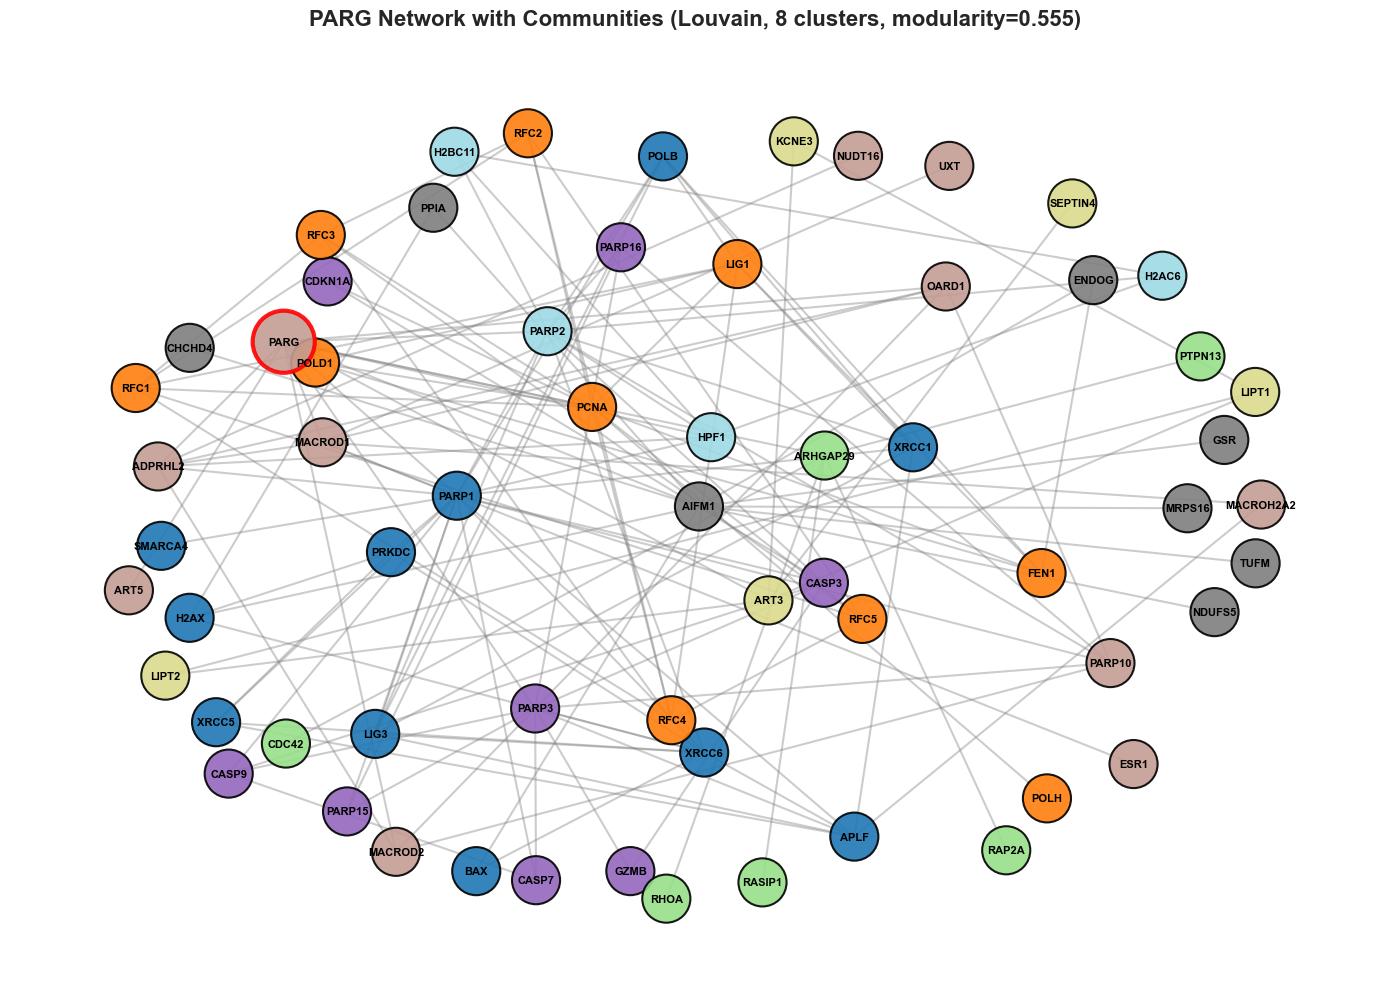


Community Detection for TP53 Network
Performing Louvain clustering...
✓ Identified 6 communities

Community sizes:
  Cluster 4: 17 proteins
  Cluster 2: 15 proteins
  Cluster 3: 14 proteins
  Cluster 0: 13 proteins
  Cluster 1: 12 proteins
  Cluster 5: 11 proteins

Network modularity: 0.6512
(Higher modularity indicates better community structure)


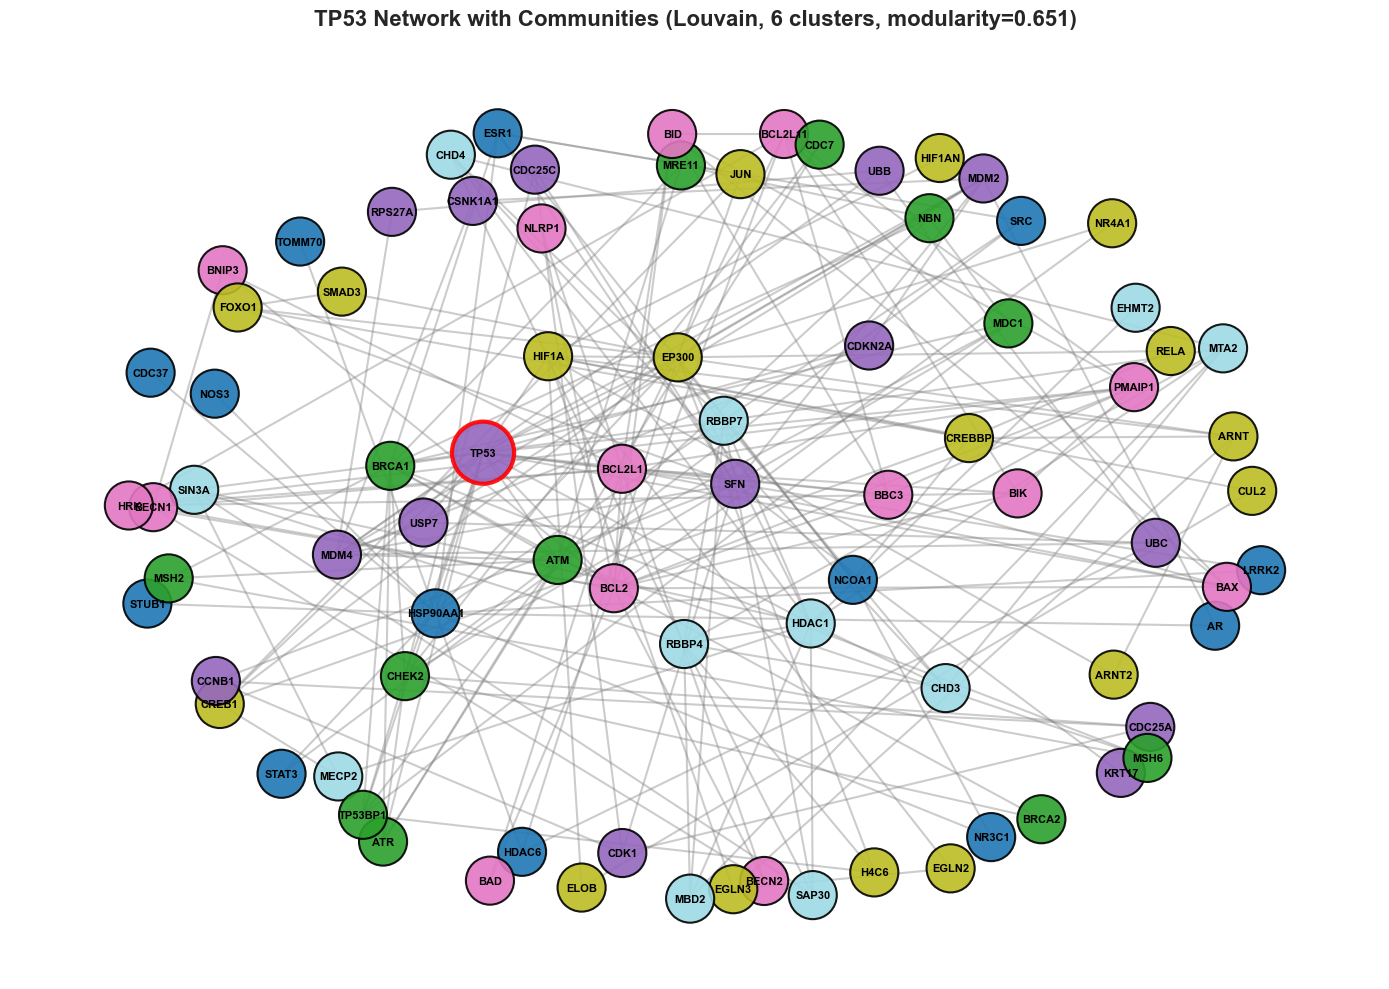


Comparison: PARG vs TP53 Communities

Number of Communities:
  PARG: 8 communities
  TP53: 6 communities

Modularity:
  PARG: 0.5547
  TP53: 0.6512

Community Size Statistics:
  PARG - Mean: 7.88, Max: 11, Min: 4
  TP53 - Mean: 13.67, Max: 17, Min: 11

Common nodes in both networks: 2
  Examples: BAX, ESR1


In [8]:
# Task 5: Community Detection using Louvain algorithm
print("=" * 60)
print("Task 5: Community Detection (Louvain Clustering)")
print("=" * 60)

# Check if Louvain is available
try:
    import community.community_louvain as community_louvain
    louvain_available = True
except ImportError:
    louvain_available = False
    print("⚠ python-louvain not installed. Using NetworkX alternative method...")

# Check if graphs were created in Task 2
if 'graphs' not in locals() or len(graphs) == 0:
    print("⚠ Warning: Graphs not found. Please run Task 2 first.")
else:
    # Store clustering results
    clustering_results = {}
    
    for protein in ["PARG", "TP53"]:
        if protein not in graphs or graphs[protein].number_of_nodes() == 0:
            print(f"⚠ Warning: No graph available for {protein}")
            continue
        
        G = graphs[protein]
        print(f"\n{'='*60}")
        print(f"Community Detection for {protein} Network")
        print(f"{'='*60}")
        
        if louvain_available:
            print("Performing Louvain clustering...")
            
            # Compute best partition
            partition = community_louvain.best_partition(G)
            
            # Organize proteins by cluster
            clusters = defaultdict(list)
            for node, cluster_id in partition.items():
                clusters[cluster_id].append(node)
            
            print(f"✓ Identified {len(clusters)} communities")
            print(f"\nCommunity sizes:")
            for cid, members in sorted(clusters.items(), key=lambda x: len(x[1]), reverse=True):
                print(f"  Cluster {cid}: {len(members)} proteins")
                if len(members) <= 10:  # Show members for small clusters
                    print(f"    Members: {', '.join(members)}")
            
            # Calculate modularity
            modularity = community_louvain.modularity(partition, G)
            print(f"\nNetwork modularity: {modularity:.4f}")
            print("(Higher modularity indicates better community structure)")
            
            clustering_results[protein] = {
                'partition': partition,
                'clusters': clusters,
                'modularity': modularity
            }
            
        else:
            # Fallback: Use NetworkX built-in community detection
            print("Using NetworkX greedy modularity communities...")
            communities = nx.community.greedy_modularity_communities(G)
            
            print(f"✓ Identified {len(communities)} communities")
            for i, comm in enumerate(sorted(communities, key=len, reverse=True), 1):
                print(f"  Community {i}: {len(comm)} proteins")
                if len(comm) <= 10:
                    print(f"    Members: {', '.join(sorted(comm))}")
            
            # Create partition dict for consistency
            partition = {}
            for i, comm in enumerate(communities):
                for node in comm:
                    partition[node] = i
            
            # Calculate modularity using NetworkX
            modularity = nx.community.modularity(G, communities)
            print(f"\nNetwork modularity: {modularity:.4f}")
            
            # Convert to clusters dict format
            clusters = defaultdict(list)
            for node, cluster_id in partition.items():
                clusters[cluster_id].append(node)
            
            clustering_results[protein] = {
                'partition': partition,
                'clusters': clusters,
                'modularity': modularity
            }
        
        # Visualize network with communities
        plt.figure(figsize=(14, 10))
        
        # Use consistent layout
        pos = nx.spring_layout(G, seed=42, k=1.5, iterations=50)
        
        # Color nodes by community
        node_colors = [partition[node] for node in G.nodes()]
        cmap = plt.cm.tab20
        
        # Highlight target protein
        node_sizes = [2000 if node == protein else 1200 for node in G.nodes()]
        node_edge_colors = ['red' if node == protein else 'black' for node in G.nodes()]
        node_linewidths = [3 if node == protein else 1.5 for node in G.nodes()]
        
        nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, 
                               cmap=cmap, alpha=0.9, edgecolors=node_edge_colors, 
                               linewidths=node_linewidths)
        nx.draw_networkx_edges(G, pos, width=1.5, alpha=0.4, edge_color='gray')
        nx.draw_networkx_labels(G, pos, font_size=8, font_weight='bold')
        
        plt.title(f"{protein} Network with Communities (Louvain, {len(clusters)} clusters, modularity={modularity:.3f})", 
                  fontsize=16, fontweight='bold', pad=20)
        plt.axis('off')
        plt.tight_layout()
        plt.show()
    
    # Compare community structures between PARG and TP53
    if len(clustering_results) == 2:
        print("\n" + "=" * 60)
        print("Comparison: PARG vs TP53 Communities")
        print("=" * 60)
        
        parg_clusters = clustering_results['PARG']['clusters']
        tp53_clusters = clustering_results['TP53']['clusters']
        
        print(f"\nNumber of Communities:")
        print(f"  PARG: {len(parg_clusters)} communities")
        print(f"  TP53: {len(tp53_clusters)} communities")
        
        print(f"\nModularity:")
        print(f"  PARG: {clustering_results['PARG']['modularity']:.4f}")
        print(f"  TP53: {clustering_results['TP53']['modularity']:.4f}")
        
        # Compare community sizes
        parg_sizes = [len(members) for members in parg_clusters.values()]
        tp53_sizes = [len(members) for members in tp53_clusters.values()]
        
        print(f"\nCommunity Size Statistics:")
        print(f"  PARG - Mean: {np.mean(parg_sizes):.2f}, Max: {max(parg_sizes)}, Min: {min(parg_sizes)}")
        print(f"  TP53 - Mean: {np.mean(tp53_sizes):.2f}, Max: {max(tp53_sizes)}, Min: {min(tp53_sizes)}")
        
        # Find common proteins in communities
        parg_all_nodes = set()
        for members in parg_clusters.values():
            parg_all_nodes.update(members)
        
        tp53_all_nodes = set()
        for members in tp53_clusters.values():
            tp53_all_nodes.update(members)
        
        common_nodes = parg_all_nodes & tp53_all_nodes
        print(f"\nCommon nodes in both networks: {len(common_nodes)}")
        
        if len(common_nodes) > 0:
            # Check if common nodes are in similar communities
            print(f"  Examples: {', '.join(list(common_nodes)[:10])}")


## Task 6: Functional Enrichment Analysis (g:Profiler)

**Aim:** Query g:Profiler API to identify enriched Gene Ontology (GO) terms and KEGG pathways for proteins in both PARG and TP53 networks. Compare the functional enrichment between the two networks to understand their biological roles.

**Background:** Functional enrichment analysis identifies which biological processes, molecular functions, cellular components, or pathways are overrepresented in a set of genes/proteins compared to the background. g:Profiler is a web-based tool that performs enrichment analysis using multiple databases including:
- **GO:BP** (Gene Ontology Biological Process): Biological processes proteins are involved in
- **GO:MF** (Gene Ontology Molecular Function): Molecular functions proteins perform
- **GO:CC** (Gene Ontology Cellular Component): Cellular locations where proteins are found
- **KEGG**: Kyoto Encyclopedia of Genes and Genomes pathways
- **REAC**: Reactome pathways

**Biological Significance:** Enrichment analysis helps interpret network data by:
- Identifying common biological functions of interacting proteins
- Revealing pathways that are overrepresented in the network
- Understanding the biological context of protein interactions
- Comparing functional profiles between different networks

**Key Concepts:**
- Functional enrichment analysis
- Statistical significance (p-values, FDR correction)
- Gene Ontology and pathway databases
- Interpreting enrichment results

Task 6: Functional Enrichment Analysis (g:Profiler)

Enrichment Analysis for PARG Network
Querying g:Profiler for 63 genes...
✓ Found 384 significantly enriched terms (p < 0.05)

Top 10 enriched terms:
           native                                                                         name      p_value source
       GO:0006974                                                          DNA damage response 1.343003e-27  GO:BP
 REAC:R-HSA-73933                                        Resolution of Abasic Sites (AP sites) 3.846035e-27   REAC
 REAC:R-HSA-73884                                                         Base Excision Repair 9.356929e-27   REAC
REAC:R-HSA-110373 Resolution of AP sites via the multiple-nucleotide patch replacement pathway 8.698823e-25   REAC
       KEGG:03410                                                         Base excision repair 1.482810e-24   KEGG
       GO:0006259                                                        DNA metabolic process 3.259158e-23 

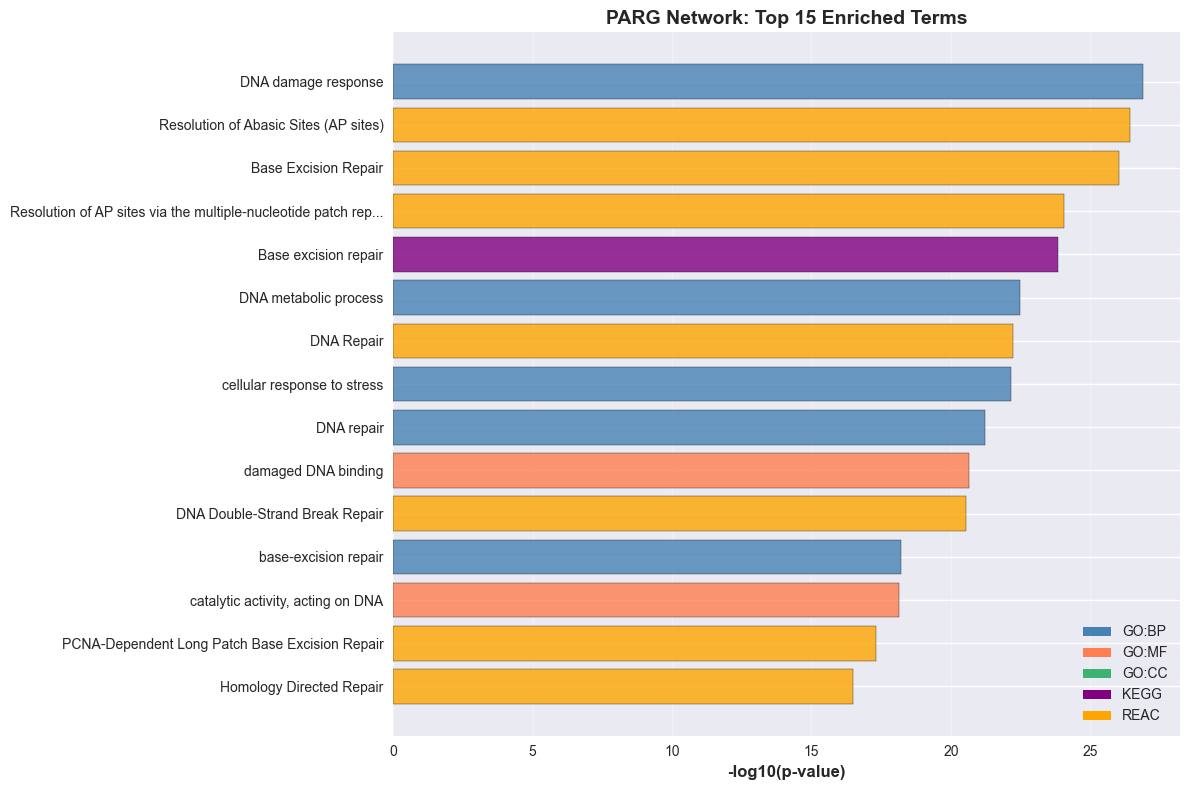


Enrichment by source (PARG):
  GO:BP: 165 enriched terms
  REAC: 90 enriched terms
  GO:MF: 70 enriched terms
  GO:CC: 48 enriched terms
  KEGG: 11 enriched terms

Enrichment Analysis for TP53 Network
Querying g:Profiler for 82 genes...
✓ Found 1441 significantly enriched terms (p < 0.05)

Top 10 enriched terms:
            native                                name      p_value source
        GO:0006915                   apoptotic process 1.399536e-30  GO:BP
        GO:0012501               programmed cell death 7.118185e-30  GO:BP
        GO:0008219                          cell death 7.864999e-30  GO:BP
        GO:0005654                         nucleoplasm 2.534880e-29  GO:CC
        GO:0042981     regulation of apoptotic process 1.995643e-28  GO:BP
REAC:R-HSA-3700989  Transcriptional Regulation by TP53 3.371103e-28   REAC
        GO:0033554         cellular response to stress 3.523518e-28  GO:BP
        GO:0043067 regulation of programmed cell death 7.176048e-28  GO:BP
        GO

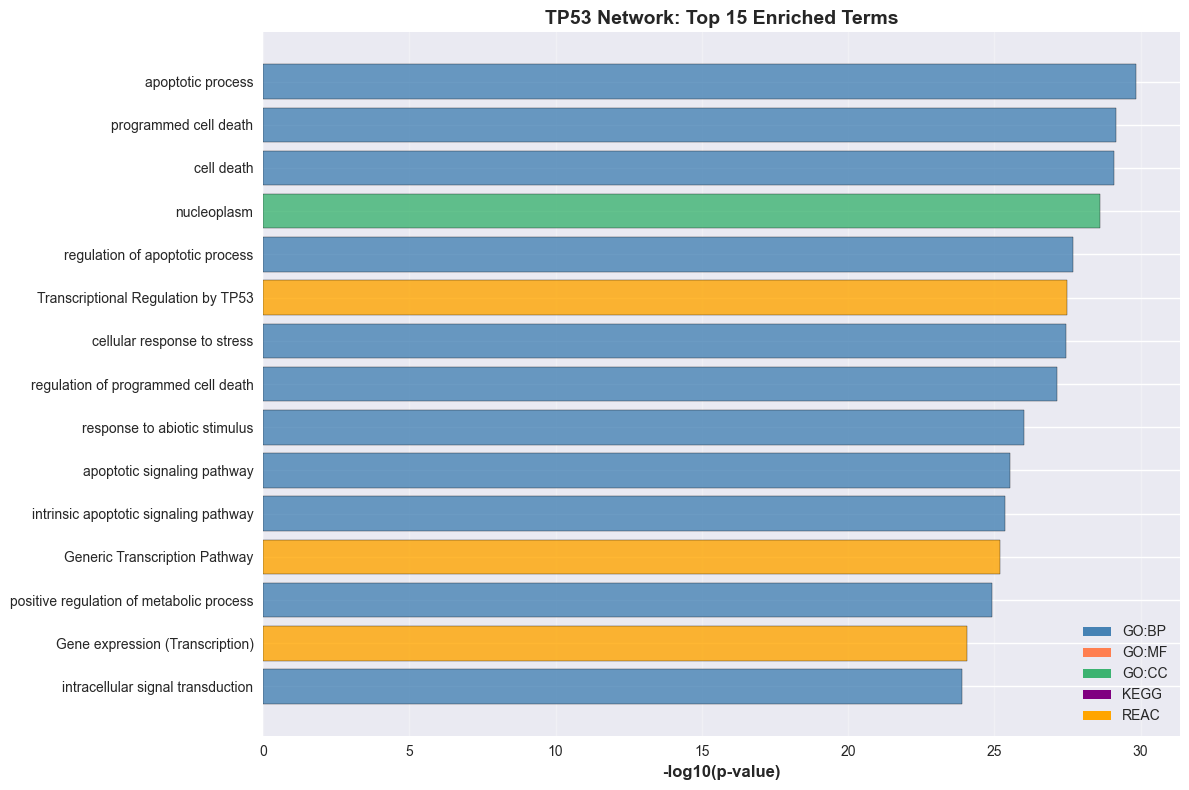


Enrichment by source (TP53):
  GO:BP: 864 enriched terms
  REAC: 314 enriched terms
  GO:MF: 122 enriched terms
  KEGG: 76 enriched terms
  GO:CC: 65 enriched terms

Comparison: PARG vs TP53 Enrichment

Number of enriched terms:
  PARG: 384 terms
  TP53: 1441 terms

Common enriched terms: 165

Top 10 common enriched terms:
            native                           name_PARG  p_value_PARG  p_value_TP53 source_PARG
        GO:0006974                 DNA damage response  1.343003e-27  1.203454e-20       GO:BP
        GO:0006259               DNA metabolic process  3.259158e-23  8.348423e-13       GO:BP
  REAC:R-HSA-73894                          DNA Repair  5.818512e-23  9.350619e-08        REAC
        GO:0033554         cellular response to stress  7.139694e-23  3.523518e-28       GO:BP
        GO:0006281                          DNA repair  5.780539e-22  4.436720e-08       GO:BP
        GO:0003684                 damaged DNA binding  2.288782e-21  1.239029e-05       GO:MF
REAC:R-HS

In [9]:
# Task 6: Functional Enrichment Analysis using g:Profiler
print("=" * 60)
print("Task 6: Functional Enrichment Analysis (g:Profiler)")
print("=" * 60)

# Check if graphs were created in Task 2
if 'graphs' not in locals() or len(graphs) == 0:
    print("⚠ Warning: Graphs not found. Please run Task 2 first.")
else:
    # Store enrichment results
    enrichment_results = {}
    
    # Query g:Profiler API
    url = "https://biit.cs.ut.ee/gprofiler/api/gost/profile/"
    
    # Color map for different sources
    source_colors = {
        'GO:BP': 'steelblue',
        'GO:MF': 'coral',
        'GO:CC': 'mediumseagreen',
        'KEGG': 'purple',
        'REAC': 'orange'
    }
    
    for protein in ["PARG", "TP53"]:
        if protein not in graphs or graphs[protein].number_of_nodes() == 0:
            print(f"⚠ Warning: No graph available for {protein}")
            continue
        
        G = graphs[protein]
        genes = list(G.nodes())
        
        print(f"\n{'='*60}")
        print(f"Enrichment Analysis for {protein} Network")
        print(f"{'='*60}")
        print(f"Querying g:Profiler for {len(genes)} genes...")
        
        payload = {
            "organism": "hsapiens",
            "query": genes,
            "sources": ["GO:BP", "GO:MF", "GO:CC", "KEGG", "REAC"],
            "user_threshold": 0.05,  # P-value threshold
            "all_results": False,
            "ordered": True
        }
        
        try:
            response = requests.post(url, json=payload, timeout=60)
            response.raise_for_status()
            
            results = response.json()
            
            # Parse and display top enriched terms
            if 'result' in results and len(results['result']) > 0:
                enrichment_df = pd.DataFrame(results['result'])
                
                # Filter by p-value and sort
                enrichment_df = enrichment_df[enrichment_df['p_value'] < 0.05].copy()
                enrichment_df = enrichment_df.sort_values('p_value')
                
                enrichment_results[protein] = enrichment_df
                
                print(f"✓ Found {len(enrichment_df)} significantly enriched terms (p < 0.05)")
                print(f"\nTop 10 enriched terms:")
                top_10 = enrichment_df.head(10)
                print(top_10[['native', 'name', 'p_value', 'source']].to_string(index=False))
                
                # Visualize top enriched terms
                top_terms = enrichment_df.head(15)
                
                if len(top_terms) > 0:
                    fig, ax = plt.subplots(figsize=(12, 8))
                    
                    y_pos = np.arange(len(top_terms))
                    colors_list = [source_colors.get(src, 'gray') for src in top_terms['source']]
                    
                    # Plot -log10(p-value)
                    neg_log_p = -np.log10(top_terms['p_value'])
                    bars = ax.barh(y_pos, neg_log_p, color=colors_list, alpha=0.8, edgecolor='black')
                    
                    ax.set_yticks(y_pos)
                    ax.set_yticklabels([name[:60] + '...' if len(name) > 60 else name 
                                        for name in top_terms['name']], fontsize=10)
                    ax.set_xlabel('-log10(p-value)', fontsize=12, fontweight='bold')
                    ax.set_title(f'{protein} Network: Top 15 Enriched Terms', fontsize=14, fontweight='bold')
                    ax.grid(axis='x', alpha=0.3)
                    ax.invert_yaxis()
                    
                    # Add legend
                    from matplotlib.patches import Patch
                    legend_elements = [Patch(facecolor=color, label=source) 
                                      for source, color in source_colors.items()]
                    ax.legend(handles=legend_elements, loc='lower right')
                    
                    plt.tight_layout()
                    plt.show()
                
                # Breakdown by source
                print(f"\nEnrichment by source ({protein}):")
                source_counts = enrichment_df['source'].value_counts()
                for source, count in source_counts.items():
                    print(f"  {source}: {count} enriched terms")
                
            else:
                print("⚠ No enrichment results found")
                enrichment_results[protein] = pd.DataFrame()
                
        except requests.exceptions.RequestException as e:
            print(f"✗ Error querying g:Profiler: {e}")
            print("Note: This may be due to network issues or API rate limits.")
            enrichment_results[protein] = pd.DataFrame()
        except Exception as e:
            print(f"✗ Error processing enrichment results: {e}")
            import traceback
            traceback.print_exc()
            enrichment_results[protein] = pd.DataFrame()
    
    # Compare enrichment between PARG and TP53
    if len(enrichment_results) == 2:
        parg_df = enrichment_results['PARG']
        tp53_df = enrichment_results['TP53']
        
        if len(parg_df) > 0 and len(tp53_df) > 0:
            print("\n" + "=" * 60)
            print("Comparison: PARG vs TP53 Enrichment")
            print("=" * 60)
            
            print(f"\nNumber of enriched terms:")
            print(f"  PARG: {len(parg_df)} terms")
            print(f"  TP53: {len(tp53_df)} terms")
            
            # Find common enriched terms
            parg_terms = set(parg_df['native'])
            tp53_terms = set(tp53_df['native'])
            common_terms = parg_terms & tp53_terms
            
            print(f"\nCommon enriched terms: {len(common_terms)}")
            if len(common_terms) > 0:
                # Show common terms with their p-values
                common_parg = parg_df[parg_df['native'].isin(common_terms)][['native', 'name', 'p_value', 'source']]
                common_tp53 = tp53_df[tp53_df['native'].isin(common_terms)][['native', 'name', 'p_value', 'source']]
                
                print(f"\nTop 10 common enriched terms:")
                # Merge to show both p-values
                merged = common_parg.merge(common_tp53, on='native', suffixes=('_PARG', '_TP53'))
                merged = merged.sort_values('p_value_PARG').head(10)
                print(merged[['native', 'name_PARG', 'p_value_PARG', 'p_value_TP53', 'source_PARG']].to_string(index=False))
            
            # Compare by source
            print(f"\nEnrichment by source:")
            print(f"  PARG:")
            for source, count in parg_df['source'].value_counts().items():
                print(f"    {source}: {count}")
            print(f"  TP53:")
            for source, count in tp53_df['source'].value_counts().items():
                print(f"    {source}: {count}")


## Task 7: Simulated Network Attack (Protein Inhibition)

**Aim:** Simulate the effect of inhibiting the central protein (TP53 or PARG) by removing it from each network. Compare graph properties before and after removal to understand the impact of targeted protein inhibition on network structure and connectivity.

**Background:** In drug discovery, targeted protein inhibition is a common therapeutic strategy. Understanding how removing a specific protein affects the network structure helps predict:
- Network robustness and resilience
- Potential side effects of inhibition
- Alternative pathways that may compensate
- Critical nodes whose removal disrupts the network

This simulation mimics what happens when a selective inhibitor blocks the function of the target protein, effectively removing it from the interaction network.

**Key Concepts:**
- Network robustness and vulnerability
- Targeted node removal
- Graph connectivity and fragmentation
- Network metrics (density, clustering, path length)
- Largest connected component analysis
- Biological implications of hub protein inhibition

Task 7: Simulated Network Attack (Protein Inhibition)

Simulating Attack: Removing PARG from Network

BEFORE removal of PARG:
  Nodes: 63
  Edges: 135
  Density: 0.0691
  Is connected: True
  Connected components: 1
  Largest component size: 63
  Average degree: 4.29
  Average clustering: 0.3777
  Average path length: 3.023
  Diameter: 4

✓ Removed PARG from network

AFTER removal of PARG:
  Nodes: 62 (lost 1)
  Edges: 122 (lost 13)
  Density: 0.0645 (change: -0.0046)
  Is connected: False
  Connected components: 4 (change: +3)
  Largest component size: 50 (lost 13 nodes)
  Average degree: 3.94 (change: -0.35)
  Average clustering: 0.3790 (change: +0.0012)

Impact Summary:
  Nodes lost: 1 (1.6%)
  Edges lost: 13 (9.6%)
  Largest component retention: 79.4%
  Network fragmentation: 3 additional components
  ⚠ Network connectivity LOST (was connected, now fragmented)


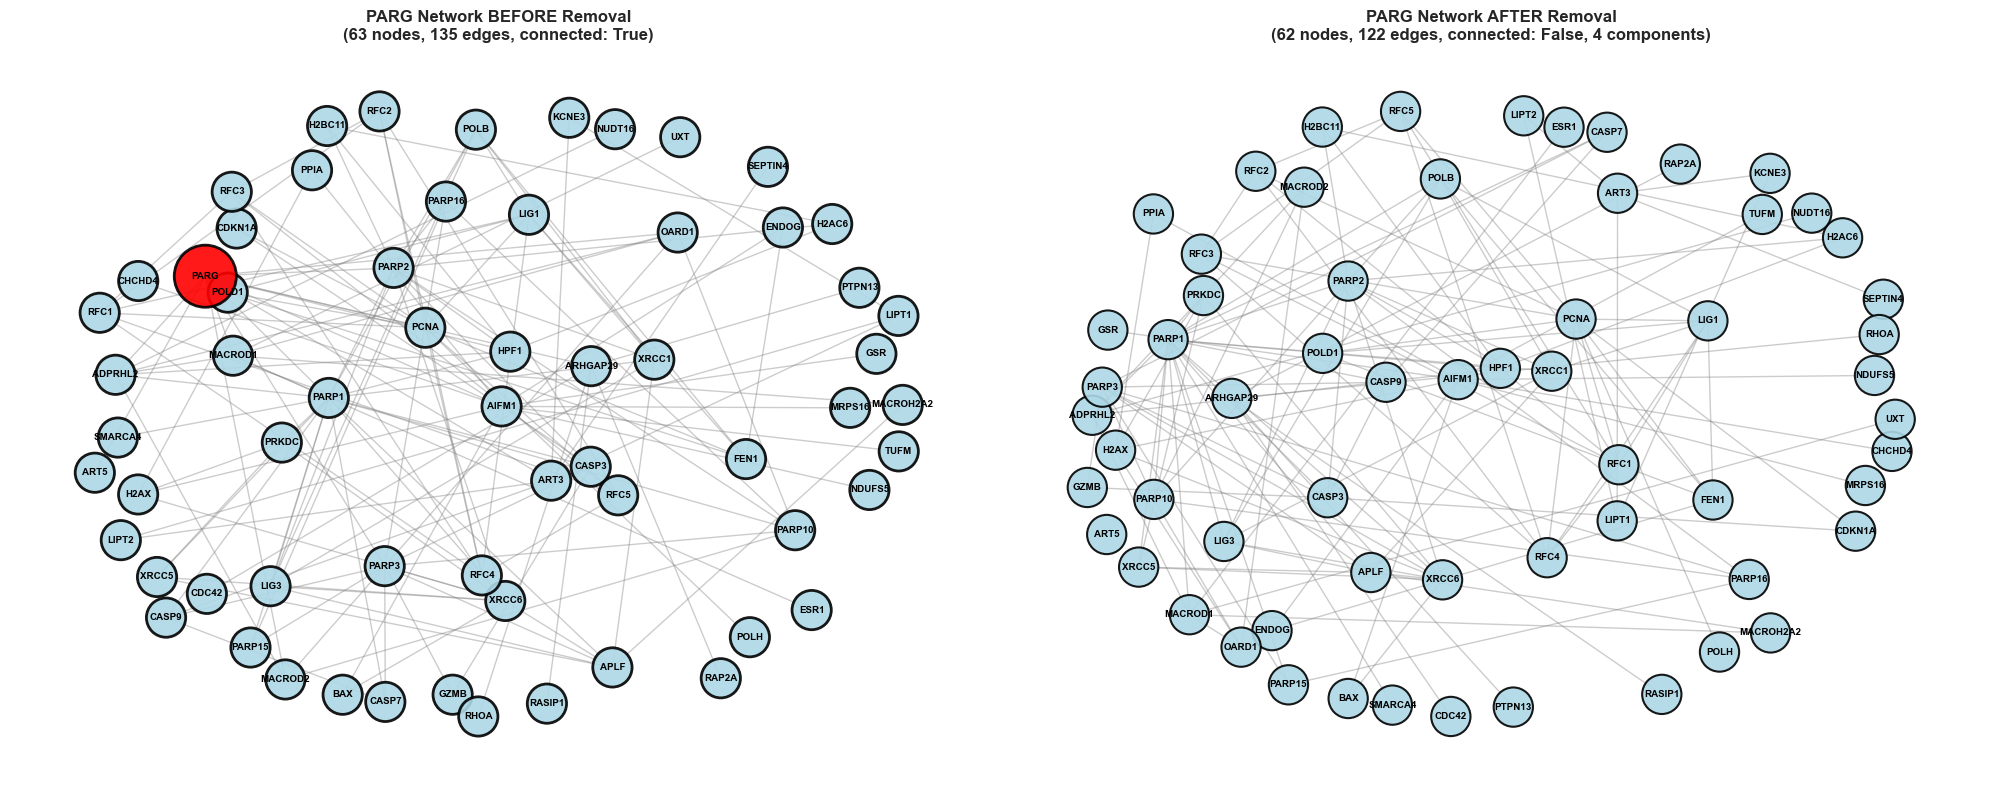

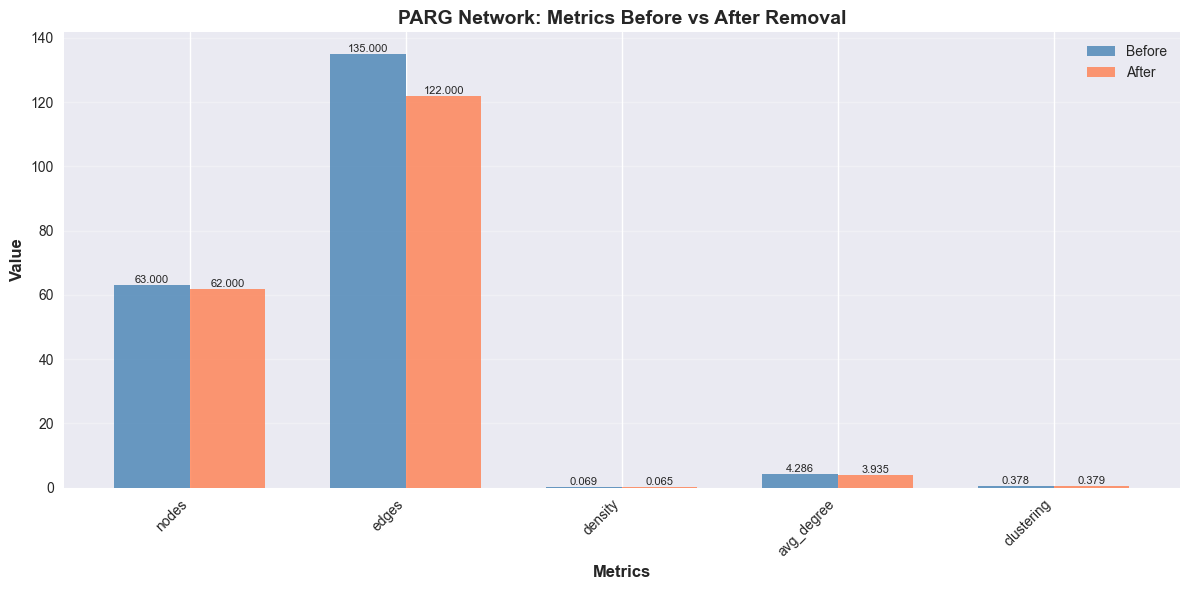


Simulating Attack: Removing TP53 from Network

BEFORE removal of TP53:
  Nodes: 82
  Edges: 202
  Density: 0.0608
  Is connected: True
  Connected components: 1
  Largest component size: 82
  Average degree: 4.93
  Average clustering: 0.5207
  Average path length: 3.043
  Diameter: 4

✓ Removed TP53 from network

AFTER removal of TP53:
  Nodes: 81 (lost 1)
  Edges: 182 (lost 20)
  Density: 0.0562 (change: -0.0047)
  Is connected: True
  Connected components: 1 (change: +0)
  Largest component size: 81 (lost 1 nodes)
  Average degree: 4.49 (change: -0.43)
  Average clustering: 0.5248 (change: +0.0041)
  Average path length: 3.828
    (change: +0.785)
  Diameter: 7

Impact Summary:
  Nodes lost: 1 (1.2%)
  Edges lost: 20 (9.9%)
  Largest component retention: 98.8%
  Network fragmentation: 0 additional components
  ✓ Network remains connected


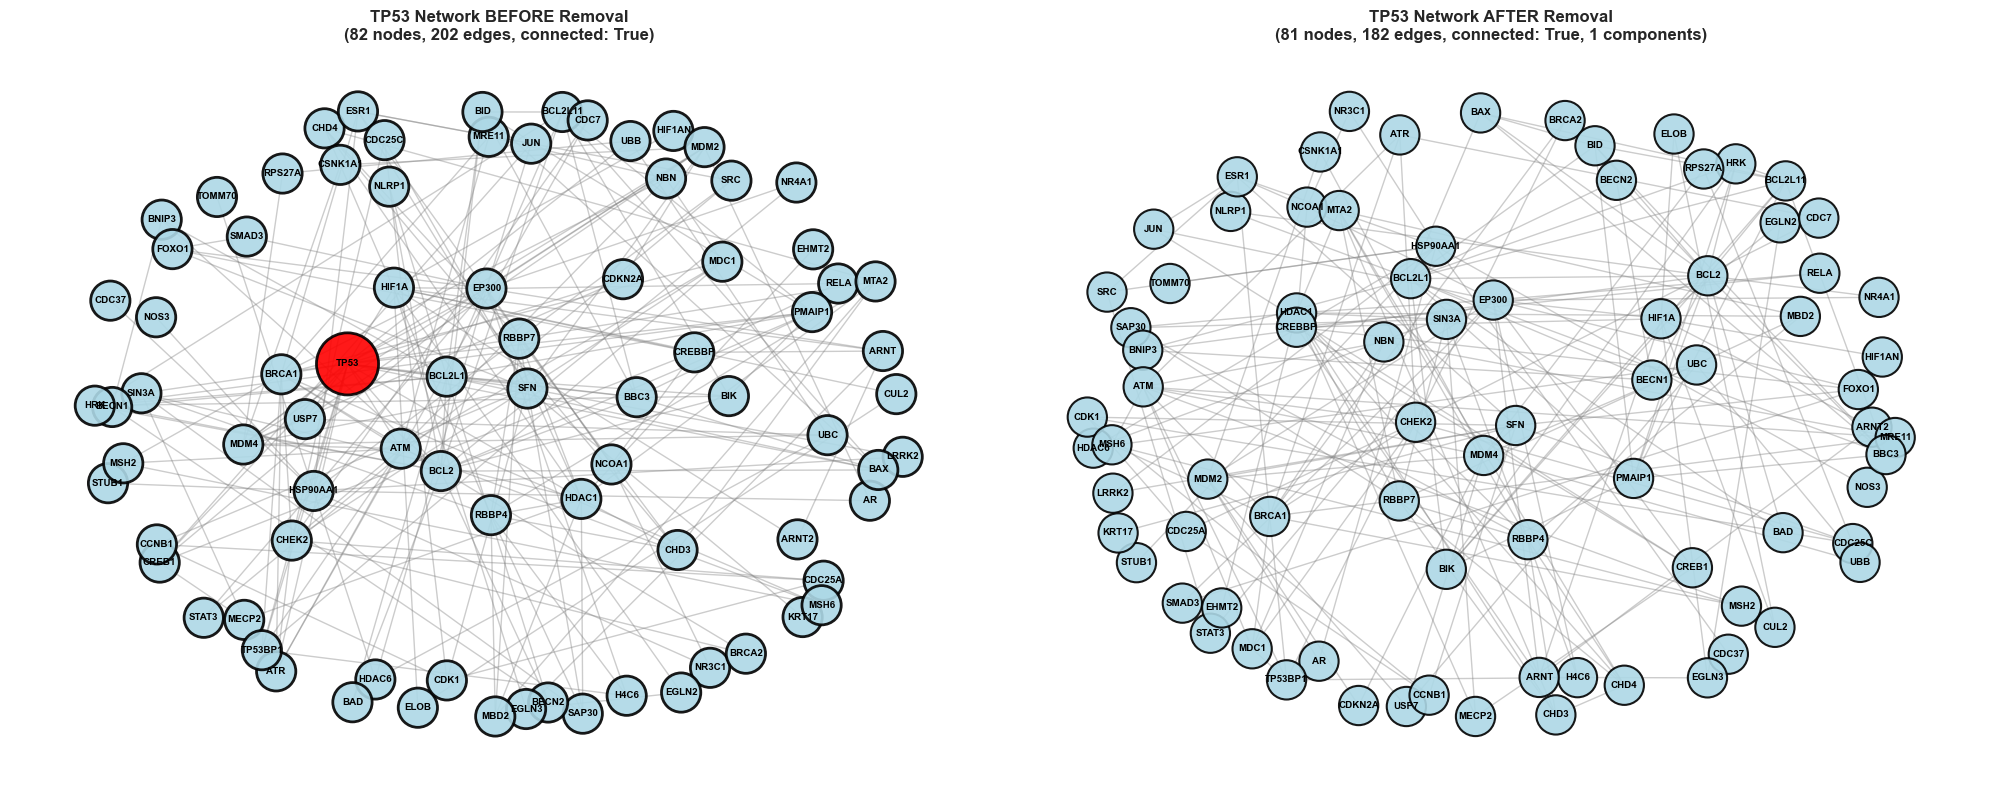

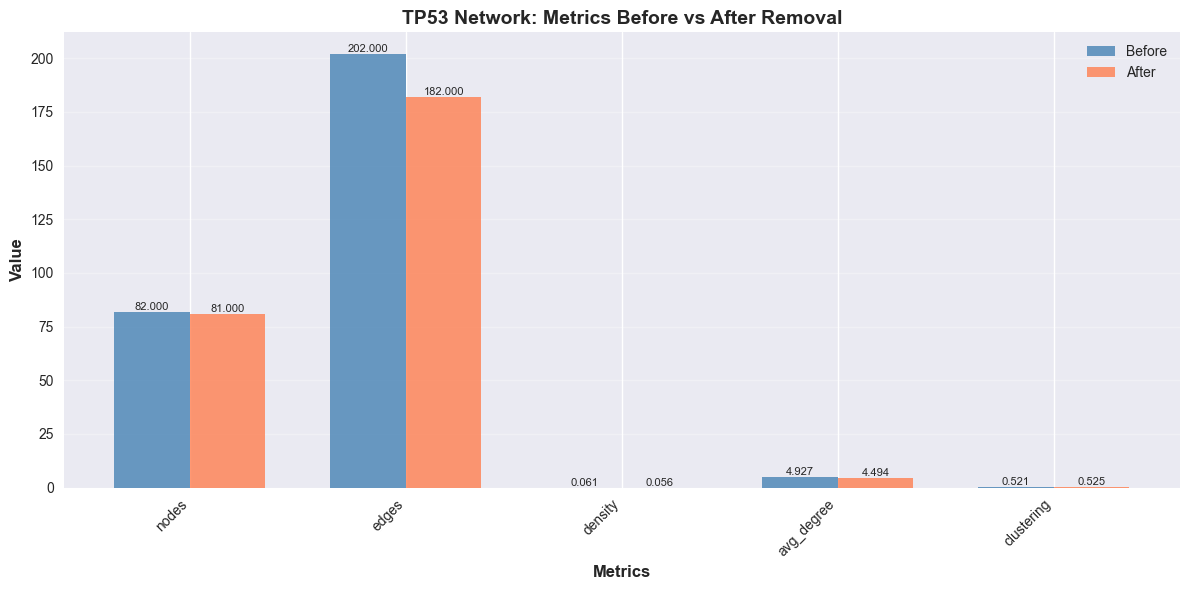


Comparison: Impact of Removing PARG vs TP53

Network Fragmentation:
  PARG removal: 3 additional components
  TP53 removal: 0 additional components

Largest Component Retention:
  PARG removal: 79.4%
  TP53 removal: 98.8%

Connectivity Loss:
  PARG removal: Network disconnected
  TP53 removal: Network remains connected

Edges Lost:
  PARG removal: 13 edges (9.6%)
  TP53 removal: 20 edges (9.9%)


In [10]:
# Task 7: Simulated Network Attack (Removing Central Proteins)
print("=" * 60)
print("Task 7: Simulated Network Attack (Protein Inhibition)")
print("=" * 60)

# Check if graphs were created in Task 2
if 'graphs' not in locals() or len(graphs) == 0:
    print("⚠ Warning: Graphs not found. Please run Task 2 first.")
else:
    # Store attack results
    attack_results = {}
    
    for protein in ["PARG", "TP53"]:
        if protein not in graphs or graphs[protein].number_of_nodes() == 0:
            print(f"⚠ Warning: No graph available for {protein}")
            continue
        
        G = graphs[protein]
        print(f"\n{'='*60}")
        print(f"Simulating Attack: Removing {protein} from Network")
        print(f"{'='*60}")
        
        # Calculate metrics BEFORE removal
        print(f"\nBEFORE removal of {protein}:")
        before_metrics = {
            'nodes': G.number_of_nodes(),
            'edges': G.number_of_edges(),
            'density': nx.density(G),
            'is_connected': nx.is_connected(G),
            'components': len(list(nx.connected_components(G))),
            'largest_component': len(max(nx.connected_components(G), key=len)) if G.number_of_nodes() > 0 else 0,
            'avg_degree': sum(dict(G.degree()).values()) / G.number_of_nodes() if G.number_of_nodes() > 0 else 0,
        }
        
        if before_metrics['is_connected']:
            before_metrics['avg_path_length'] = nx.average_shortest_path_length(G)
            before_metrics['diameter'] = nx.diameter(G)
        else:
            before_metrics['avg_path_length'] = None
            before_metrics['diameter'] = None
        
        before_metrics['clustering'] = nx.average_clustering(G)
        
        print(f"  Nodes: {before_metrics['nodes']}")
        print(f"  Edges: {before_metrics['edges']}")
        print(f"  Density: {before_metrics['density']:.4f}")
        print(f"  Is connected: {before_metrics['is_connected']}")
        print(f"  Connected components: {before_metrics['components']}")
        print(f"  Largest component size: {before_metrics['largest_component']}")
        print(f"  Average degree: {before_metrics['avg_degree']:.2f}")
        print(f"  Average clustering: {before_metrics['clustering']:.4f}")
        if before_metrics['avg_path_length']:
            print(f"  Average path length: {before_metrics['avg_path_length']:.3f}")
            print(f"  Diameter: {before_metrics['diameter']}")
        
        # Remove the central protein
        G_attacked = G.copy()
        if protein in G_attacked.nodes():
            G_attacked.remove_node(protein)
            print(f"\n✓ Removed {protein} from network")
        else:
            print(f"⚠ Warning: {protein} not found in graph nodes")
        
        # Calculate metrics AFTER removal
        print(f"\nAFTER removal of {protein}:")
        after_metrics = {
            'nodes': G_attacked.number_of_nodes(),
            'edges': G_attacked.number_of_edges(),
            'density': nx.density(G_attacked) if G_attacked.number_of_nodes() > 0 else 0,
            'is_connected': nx.is_connected(G_attacked) if G_attacked.number_of_nodes() > 0 else False,
            'components': len(list(nx.connected_components(G_attacked))) if G_attacked.number_of_nodes() > 0 else 0,
            'largest_component': len(max(nx.connected_components(G_attacked), key=len)) if G_attacked.number_of_nodes() > 0 else 0,
            'avg_degree': sum(dict(G_attacked.degree()).values()) / G_attacked.number_of_nodes() if G_attacked.number_of_nodes() > 0 else 0,
        }
        
        if after_metrics['is_connected'] and G_attacked.number_of_nodes() > 1:
            after_metrics['avg_path_length'] = nx.average_shortest_path_length(G_attacked)
            after_metrics['diameter'] = nx.diameter(G_attacked)
        else:
            after_metrics['avg_path_length'] = None
            after_metrics['diameter'] = None
        
        after_metrics['clustering'] = nx.average_clustering(G_attacked) if G_attacked.number_of_nodes() > 0 else 0
        
        print(f"  Nodes: {after_metrics['nodes']} (lost {before_metrics['nodes'] - after_metrics['nodes']})")
        print(f"  Edges: {after_metrics['edges']} (lost {before_metrics['edges'] - after_metrics['edges']})")
        print(f"  Density: {after_metrics['density']:.4f} (change: {after_metrics['density'] - before_metrics['density']:+.4f})")
        print(f"  Is connected: {after_metrics['is_connected']}")
        print(f"  Connected components: {after_metrics['components']} (change: {after_metrics['components'] - before_metrics['components']:+d})")
        print(f"  Largest component size: {after_metrics['largest_component']} (lost {before_metrics['largest_component'] - after_metrics['largest_component']} nodes)")
        print(f"  Average degree: {after_metrics['avg_degree']:.2f} (change: {after_metrics['avg_degree'] - before_metrics['avg_degree']:+.2f})")
        print(f"  Average clustering: {after_metrics['clustering']:.4f} (change: {after_metrics['clustering'] - before_metrics['clustering']:+.4f})")
        if after_metrics['avg_path_length']:
            print(f"  Average path length: {after_metrics['avg_path_length']:.3f}")
            if before_metrics['avg_path_length']:
                print(f"    (change: {after_metrics['avg_path_length'] - before_metrics['avg_path_length']:+.3f})")
            print(f"  Diameter: {after_metrics['diameter']}")
        
        # Calculate impact metrics
        impact = {
            'nodes_lost': before_metrics['nodes'] - after_metrics['nodes'],
            'edges_lost': before_metrics['edges'] - after_metrics['edges'],
            'largest_component_loss': before_metrics['largest_component'] - after_metrics['largest_component'],
            'largest_component_retention': after_metrics['largest_component'] / before_metrics['largest_component'] if before_metrics['largest_component'] > 0 else 0,
            'fragmentation': after_metrics['components'] - before_metrics['components'],
            'connectivity_lost': not after_metrics['is_connected'] if before_metrics['is_connected'] else False
        }
        
        print(f"\nImpact Summary:")
        print(f"  Nodes lost: {impact['nodes_lost']} ({impact['nodes_lost']/before_metrics['nodes']*100:.1f}%)")
        print(f"  Edges lost: {impact['edges_lost']} ({impact['edges_lost']/before_metrics['edges']*100:.1f}%)")
        print(f"  Largest component retention: {impact['largest_component_retention']*100:.1f}%")
        print(f"  Network fragmentation: {impact['fragmentation']} additional components")
        if impact['connectivity_lost']:
            print(f"  ⚠ Network connectivity LOST (was connected, now fragmented)")
        elif not after_metrics['is_connected']:
            print(f"  Network remains disconnected (was already disconnected)")
        else:
            print(f"  ✓ Network remains connected")
        
        attack_results[protein] = {
            'before': before_metrics,
            'after': after_metrics,
            'impact': impact,
            'graph_attacked': G_attacked
        }
        
        # Visualize before and after
        fig, axes = plt.subplots(1, 2, figsize=(20, 8))
        
        # Before removal
        pos_before = nx.spring_layout(G, seed=42, k=1.5, iterations=50)
        node_colors_before = ['red' if node == protein else 'lightblue' for node in G.nodes()]
        node_sizes_before = [2000 if node == protein else 800 for node in G.nodes()]
        
        nx.draw_networkx_nodes(G, pos_before, node_color=node_colors_before, 
                               node_size=node_sizes_before, alpha=0.9, 
                               edgecolors='black', linewidths=2, ax=axes[0])
        nx.draw_networkx_edges(G, pos_before, width=1, alpha=0.4, 
                               edge_color='gray', ax=axes[0])
        nx.draw_networkx_labels(G, pos_before, font_size=7, font_weight='bold', ax=axes[0])
        axes[0].set_title(f'{protein} Network BEFORE Removal\n'
                         f'({before_metrics["nodes"]} nodes, {before_metrics["edges"]} edges, '
                         f'connected: {before_metrics["is_connected"]})',
                         fontsize=12, fontweight='bold')
        axes[0].axis('off')
        
        # After removal
        if G_attacked.number_of_nodes() > 0:
            pos_after = nx.spring_layout(G_attacked, seed=42, k=1.5, iterations=50)
            node_colors_after = ['lightblue' for node in G_attacked.nodes()]
            node_sizes_after = [800 for node in G_attacked.nodes()]
            
            nx.draw_networkx_nodes(G_attacked, pos_after, node_color=node_colors_after,
                                  node_size=node_sizes_after, alpha=0.9,
                                  edgecolors='black', linewidths=1.5, ax=axes[1])
            nx.draw_networkx_edges(G_attacked, pos_after, width=1, alpha=0.4,
                                  edge_color='gray', ax=axes[1])
            nx.draw_networkx_labels(G_attacked, pos_after, font_size=7, 
                                    font_weight='bold', ax=axes[1])
            axes[1].set_title(f'{protein} Network AFTER Removal\n'
                             f'({after_metrics["nodes"]} nodes, {after_metrics["edges"]} edges, '
                             f'connected: {after_metrics["is_connected"]}, '
                             f'{after_metrics["components"]} components)',
                             fontsize=12, fontweight='bold')
        else:
            axes[1].text(0.5, 0.5, 'Network completely\ndisconnected', 
                        ha='center', va='center', fontsize=14, fontweight='bold')
            axes[1].set_title(f'{protein} Network AFTER Removal\n(No nodes remaining)',
                             fontsize=12, fontweight='bold')
        axes[1].axis('off')
        
        plt.tight_layout()
        plt.show()
        
        # Bar plot comparing metrics
        metrics_to_compare = ['nodes', 'edges', 'density', 'avg_degree', 'clustering']
        before_values = [before_metrics[m] for m in metrics_to_compare]
        after_values = [after_metrics[m] for m in metrics_to_compare]
        
        fig, ax = plt.subplots(figsize=(12, 6))
        x = np.arange(len(metrics_to_compare))
        width = 0.35
        
        bars1 = ax.bar(x - width/2, before_values, width, label='Before', color='steelblue', alpha=0.8)
        bars2 = ax.bar(x + width/2, after_values, width, label='After', color='coral', alpha=0.8)
        
        ax.set_xlabel('Metrics', fontsize=12, fontweight='bold')
        ax.set_ylabel('Value', fontsize=12, fontweight='bold')
        ax.set_title(f'{protein} Network: Metrics Before vs After Removal', 
                    fontsize=14, fontweight='bold')
        ax.set_xticks(x)
        ax.set_xticklabels(metrics_to_compare, rotation=45, ha='right')
        ax.legend()
        ax.grid(axis='y', alpha=0.3)
        
        # Add value labels on bars
        for bars in [bars1, bars2]:
            for bar in bars:
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height,
                       f'{height:.3f}', ha='center', va='bottom', fontsize=8)
        
        plt.tight_layout()
        plt.show()
    
    # Compare impact between PARG and TP53 removal
    if len(attack_results) == 2:
        print("\n" + "=" * 60)
        print("Comparison: Impact of Removing PARG vs TP53")
        print("=" * 60)
        
        parg_impact = attack_results['PARG']['impact']
        tp53_impact = attack_results['TP53']['impact']
        
        print(f"\nNetwork Fragmentation:")
        print(f"  PARG removal: {parg_impact['fragmentation']} additional components")
        print(f"  TP53 removal: {tp53_impact['fragmentation']} additional components")
        
        print(f"\nLargest Component Retention:")
        print(f"  PARG removal: {parg_impact['largest_component_retention']*100:.1f}%")
        print(f"  TP53 removal: {tp53_impact['largest_component_retention']*100:.1f}%")
        
        print(f"\nConnectivity Loss:")
        print(f"  PARG removal: {'Network disconnected' if parg_impact['connectivity_lost'] else 'Network remains connected'}")
        print(f"  TP53 removal: {'Network disconnected' if tp53_impact['connectivity_lost'] else 'Network remains connected'}")
        
        print(f"\nEdges Lost:")
        print(f"  PARG removal: {parg_impact['edges_lost']} edges ({parg_impact['edges_lost']/attack_results['PARG']['before']['edges']*100:.1f}%)")
        print(f"  TP53 removal: {tp53_impact['edges_lost']} edges ({tp53_impact['edges_lost']/attack_results['TP53']['before']['edges']*100:.1f}%)")